# crms_repr-celltype-pattern_rec


THis is an update of `crms_repr-celltype-pattern_rec`, `crms_representation-cell-type-specific.ipynb`, focused on find patterns found in the data,

05/11/2020

test cell-type specific prediction

todo
- test model performance with only certan parameters
- edit the model type
- set up sequence information

# 0. startup


In [1]:
import os, glob
import itertools
from collections import Counter, defaultdict
import time

import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_style('whitegrid');#sns.set_style("whitegrid")

import matplotlib
import matplotlib.pyplot as plt

from scipy import interp

from scipy.stats.stats import pearsonr
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder #StandardScaler 
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve,average_precision_score,plot_roc_curve, confusion_matrix, accuracy_score


# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
save_dir = '../data/processed/fig4_modelling'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
THRES=1

In [5]:
normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal',#'GDSD0','GDSD3',
                  'GDSD6','GM12878','HMEC','Melanocytes','Ovarian',
'Pancreas','Prostate','Renal','Thyroid','Uterine']
normal_tissues_dict = dict(zip(normal_tissues,range(len(normal_tissues))))

In [6]:
# hoco_annon_file = 'annon/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv'
# hoco_annon = pd.read_table(hoco_annon_file,header=0)
# hoco_annon[['motif_abbr','motif_info']]=hoco_annon['Model'].str.split("_",expand=True)
# hoco_motif_t|o_tf = pd.Series(hoco_annon['Transcription factor'].values, index=hoco_annon.motif_abbr.values).to_dict()
# tfs = list(hoco_annon['Transcription factor'])

##  1. Data preprocessing and importing

iteracte through and choose different feature versions to find best)

found comb >~ distal portion of comb > pro > sum

pro_and_dist_sum is from sep

need to do scrambles - only for gex expression prediction
```
['../data/processed/tissue_crms/all_count_pro_overall.csv',
 '../data/processed/tissue_crms/all_count_sum_overall.csv',
 '../data/processed/tissue_crms/all_count_comb_overall.csv',
 '../data/processed/tissue_crms/all_count_sep_overall.csv']
 ```
 ```
dist_tf_only - tf only features, only use the distal loops
dist_all - all features, only use the distal loops
comb_tf_only - tf only features, using distal and proximal information separately
comb_all - all features,using distal and proximal information separately
proxall_tf_only- tf only features, using proximal information (proximal anchor and proximal TSS info. summed)
prom_tf_only- tf only features, using proximal information (proximal TSS info only)
sum_tf_only- tf only features, irrespective if in proximal or looped region
pro_dist_sum_tf_only - tf only features, using proximal information (proximal TSS info only) and distal information, summed
pro_dist_sum_all - all features, using proximal information (proximal TSS info only) and distal information, summed

pro_dist_sep_tf_only - tf only features, using proximal information (proximal TSS info only) and distal information, separate

pro_no_tf - no tf features promoter only (ATAC)
comb_no_tf - no tf features HiCHIP +atac 
```

In [95]:
save_prefix = 'comb_no_tf' # comb >~ sep > pro > sum
data_type = 'comb'

In [96]:
# glob.glob('../data/processed/tissue_crms_random/all_count_sep_overall.csv')
'random' in save_prefix

False

In [97]:
%%time
if 'random' in save_prefix:
    data_all = pd.read_csv('../data/processed/tissue_crms_random/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
else:
    data_all = pd.read_csv('../data/processed/tissue_crms/all_count_'+data_type +'_overall.csv',index_col=0,header=0)

data_all = data_all[data_all.tissue.isin(normal_tissues)]
print(data_all.shape)
# filter for crms with data, 
data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]
print(data_all.shape)


(372165, 1063)
(137054, 1063)
CPU times: user 1min 22s, sys: 21.9 s, total: 1min 44s
Wall time: 1min 28s


In [98]:
display(data_all[:5])
data_all.columns

,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A4GALT,Airway,5.435,45.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4GNT,Airway,0.000,5060.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAMP,Airway,43.710,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AANAT,Airway,0.000,13.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABAT,Airway,0.125,21.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['tissue', 'exp', 'num_loop_counts', 'num_loops', 'num_atac_regions_pro',
       'num_atac_regions_loop', 'AHR_pro', 'ARID5B_pro', 'ARNT_pro',
       'ARNTL_pro',
       ...
       'MAFA_loop', 'MEOX1_loop', 'E2F5_pro', 'E2F5_loop', 'ESR2_pro',
       'KLF14_pro', 'TBX15_pro', 'ESR2_loop', 'KLF14_loop', 'TBX15_loop'],
      dtype='object', length=1063)

In [99]:
%%time
## only proxall and dist (both promoter and closest 5kb region) , or pro_dist_sum_all
if ('proxall' in save_prefix )or ('dist' in save_prefix):
    features_to_drop = []
    for feature in data_all.columns.values:
        if feature.endswith('_pro') :#_anc, _pro, _loop
    #         print(feature)
            features_to_drop.append(feature)
    print(len(features_to_drop))
    data_all.drop(features_to_drop,axis=1,inplace=True)

    print(data_all.shape)
    data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]
    print('post proximal feature removal',data_all.shape)


    ## only tfs
if ('tf_only' in save_prefix):
    for feature in ['tissue','exp','num_loop_counts','num_loops','num_atac_regions', 'num_atac_regions_pro','num_atac_regions_loop']:
        if feature in data_all.columns.values:
            data_all.drop(feature,axis=1,inplace=True)

    print('tf only',data_all.shape)


## only proxall and dist (both promoter and closest 5kb region) , or pro_dist_sum_all
if ('no_tf' in save_prefix ):
    features_to_drop = []
    for feature in data_all.columns.to_list()[2:]:
        if not feature.startswith('num') :#_anc, _pro, _loop
    #         print(feature)
            features_to_drop.append(feature)
    
    print(len(features_to_drop))#,features_to_drop)
    data_all.drop(features_to_drop,axis=1,inplace=True)

    print('no tf',data_all.shape)
#     data_all = data_all[data_all.iloc[:,2:].sum(axis=1)>1e-1]
#     print(data_all.shape)



1057
no tf (137054, 6)
CPU times: user 4.57 ms, sys: 54.1 ms, total: 58.7 ms
Wall time: 57.8 ms


In [100]:
exp_label = list(data_all.exp.values)
exp_label_bin  = np.array((data_all.exp>THRES).values)



preprocess genes by converting into number

In [101]:
genes_all = data_all.index.values
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)

In [102]:
len(np.unique(genes_all))

15476

 preprocess tissues

In [103]:
tissue_labels = data_all.tissue.values
tissue_num_labels =  data_all.tissue.map(normal_tissues_dict).values
tissue_labels.shape

(137054,)

In [104]:
# pd.read_csv('../../networks/diffgene/all_no_thres/all_Air_crm_tissue.csv').shape

In [105]:
Counter(tissue_labels)

Counter({'Airway': 5771,
         'Astrocytes': 7990,
         'Bladder': 8771,
         'Colon': 10518,
         'Esophageal': 9587,
         'GDSD6': 8812,
         'GM12878': 9009,
         'HMEC': 7885,
         'Melanocytes': 6887,
         'Ovarian': 9670,
         'Pancreas': 8943,
         'Prostate': 10675,
         'Renal': 10208,
         'Thyroid': 9963,
         'Uterine': 12365})

In [106]:
data_all.columns

Index(['tissue', 'exp', 'num_loop_counts', 'num_loops', 'num_atac_regions_pro',
       'num_atac_regions_loop'],
      dtype='object')

In [107]:
data_all.columns

Index(['tissue', 'exp', 'num_loop_counts', 'num_loops', 'num_atac_regions_pro',
       'num_atac_regions_loop'],
      dtype='object')

In [108]:
## normal version
data_all.drop('tissue',axis=1,inplace=True)
data_all['gene_num'] = genes_num_all
   
data_all.shape




(137054, 6)

In [109]:
# %%time
# # for pro_dist_sum_tf_only and pro_dist_sum_all
# tfs_to_features =defaultdict(list)
# tfs_to_features['exp'] = ['exp']
# tfs_to_features['num_loop_counts'] = ['num_loop_counts']
# tfs_to_features['num_loops'] = ['num_loops']
# tfs_to_features['num_atac_regions'] = ['num_atac_regions_pro','num_atac_regions_loop']

# for feature in data_all.columns.values:
    
#     if ('num' not in feature ) and ('exp' not in feature ):
# #         print(feature)
#         tf =feature.split('_')[0]
#         tfs_to_features[tf].append(feature)
# print(len(tfs_to_features.keys()))
# data_all_new = pd.DataFrame(index=data_all.index)
# for tf, feature_arr in tfs_to_features.items():
#     data_all_new[tf] = data_all[feature_arr].sum(axis=1)
# data_all = data_all_new
# data_all.shape


In [110]:
# preprocessing, remove zero variance columns, and scale rest of columns 
    
selector = VarianceThreshold()
data_all_varfilt = selector.fit_transform(data_all)
data_all_varfilt_cols = data_all.columns[selector.get_support()]
print(data_all.shape, data_all_varfilt.shape, len(data_all_varfilt_cols))
scaler = MinMaxScaler()
data_all_norm = scaler.fit_transform(data_all_varfilt)
print(data_all_varfilt.shape, data_all_norm.shape)


(137054, 6) (137054, 6) 6
(137054, 6) (137054, 6)


## 2A: Classification:
Random Forest, SVM, etc
### 2A.0: Random Forest basic testing:


In [111]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_labels,
                                                                            test_size = 0.25, random_state = 80)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())
Counter(test_labels)

Training Features Shape: (102790, 6)
Training Labels Shape: (102790,)
Testing Features Shape: (34264, 6)
Testing Labels Shape: (34264,)


Counter({'GDSD6': 2177,
         'Colon': 2584,
         'Uterine': 3167,
         'Ovarian': 2451,
         'Renal': 2573,
         'Prostate': 2684,
         'Esophageal': 2346,
         'Thyroid': 2430,
         'Melanocytes': 1707,
         'Bladder': 2299,
         'HMEC': 2036,
         'Pancreas': 2207,
         'Astrocytes': 1979,
         'GM12878': 2233,
         'Airway': 1391})

In [112]:
%%time
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
#                                max_depth=5,
                               
                               n_jobs=-1, verbose = 0)
# Fit on training data
model.fit(train_features, train_labels)
# Actual class predictions
rf_predictions = model.predict(test_features)


CPU times: user 1min 3s, sys: 5.31 s, total: 1min 8s
Wall time: 5.48 s


In [113]:
# fpr, tpr, thresholds = metrics.roc_curve(test_labels, rf_probs, pos_label=1)
# fig, ax = plt.subplots()
# ax.plot(fpr,tpr)
# plot_roc_curve(model, test_features, test_labels, multi_class='ovr') 

In [114]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(data_all_varfilt_cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.to_csv(os.path.join(save_dir, save_prefix+'_feature_importance.csv'))

# Display
fi.head(10)

,feature,importance
5,gene_num,0.278395
0,exp,0.253051
1,num_loop_counts,0.181846
4,num_atac_regions_loop,0.154451
2,num_loops,0.096202
3,num_atac_regions_pro,0.036054


In [115]:
# evaluation
acc = accuracy_score(test_labels, rf_predictions)
print(acc)
# Probabilities for each class
rf_probs = model.predict_proba(test_features)
# # Calculate roc auc
roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
print(roc_value)

0.1554109269203829
0.6676100447529216


In [116]:
test_labels_num = np.vectorize(normal_tissues_dict.get)(test_labels)
test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)


In [117]:
rf_probs[1,:]

array([0.01 , 0.05 , 0.03 , 0.1  , 0.045, 0.045, 0.045, 0.045, 0.   ,
       0.125, 0.05 , 0.065, 0.105, 0.085, 0.2  ])

In [118]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
precision = dict()
recall = dict()
roc_auc = dict()
roc_prc = dict()
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:,i], rf_probs[:, i])
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:,i], rf_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_prc[i] = average_precision_score(test_labels_bin[:,i], rf_probs[:, i])
    print(model.classes_[i], roc_auc[i], roc_prc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), rf_probs.ravel())
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels_bin.ravel(), rf_probs.ravel())

roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_prc["micro"] = average_precision_score(test_labels_bin, rf_probs,
                                                     average="micro")

print('micro average', roc_auc["micro"], roc_prc['micro'])

Airway 0.874409265573676 0.2737840133257697
Astrocytes 0.7484104156051424 0.1758750456414227
Bladder 0.5913176772087947 0.0905901170729804
Colon 0.6386288325886575 0.1252122485564654
Esophageal 0.6547518104657251 0.11120861544807717
GDSD6 0.6018958791110509 0.08849273726306717
GM12878 0.5794983680092826 0.08739765021885462
HMEC 0.5906662116164957 0.07862564913493292
Melanocytes 0.7122940291695882 0.10934460428329805
Ovarian 0.6632621453220685 0.13549802419565737
Pancreas 0.6624269985558545 0.10786609815146195
Prostate 0.7580102375251178 0.22503969293175002
Renal 0.6357345290941754 0.135485844088113
Thyroid 0.6126689157308063 0.09869193477679364
Uterine 0.6780335543978989 0.2583192557049905
micro average 0.6755407114603394 0.1437795217384599


In [119]:
normal_tissues_dict

{'Airway': 0,
 'Astrocytes': 1,
 'Bladder': 2,
 'Colon': 3,
 'Esophageal': 4,
 'GDSD6': 5,
 'GM12878': 6,
 'HMEC': 7,
 'Melanocytes': 8,
 'Ovarian': 9,
 'Pancreas': 10,
 'Prostate': 11,
 'Renal': 12,
 'Thyroid': 13,
 'Uterine': 14}

In [120]:
# saving
auc_df = pd.DataFrame.from_dict({'tissue':list(model.classes_)+['micro'],'LOO-AUROC': list(roc_auc.values())},orient='columns')
auc_df.to_csv(os.path.join(save_dir, save_prefix+'_auc_tissue.csv'))

prc_df = pd.DataFrame.from_dict({'tissue':list(model.classes_)+['micro'],'LOO-AUROC': list(roc_prc.values())},orient='columns')
prc_df.to_csv(os.path.join(save_dir, save_prefix+'_prc_tissue.csv'))



In [121]:
# saving tpr 
pd.DataFrame.from_dict({'fpr':fpr["micro"],'tpr': tpr["micro"]},orient='columns').to_csv(os.path.join(save_dir, save_prefix+'_auc_curve_values.csv'))
pd.DataFrame.from_dict({'precision':precision["micro"],'recall': recall["micro"]},orient='columns').to_csv(os.path.join(save_dir, save_prefix+'_prc_curve_values.csv'))

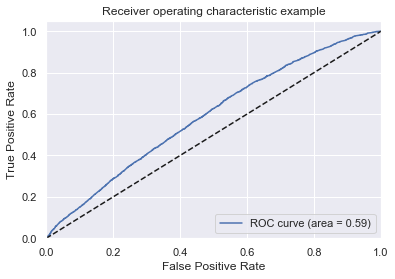

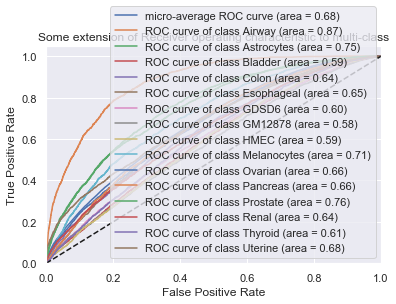

In [122]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

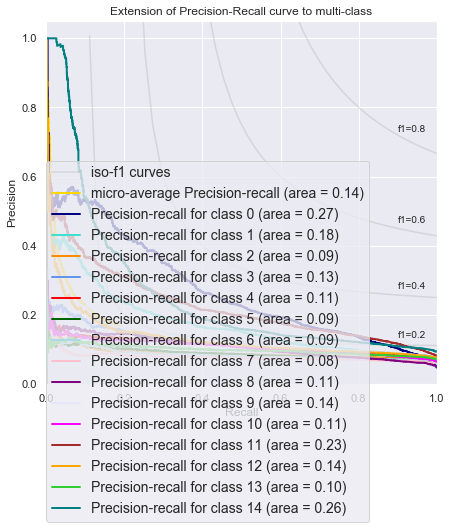

In [123]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red','darkgreen', 'lightblue','pink', 
                'purple','lavender', 'magenta', 'brown', 'orange', 'limegreen', 'teal','lightgreen'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(roc_prc["micro"]))

for i, color in zip(range(len(model.classes_)), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, roc_prc[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

In [124]:
Counter(test_labels)

Counter({'GDSD6': 2177,
         'Colon': 2584,
         'Uterine': 3167,
         'Ovarian': 2451,
         'Renal': 2573,
         'Prostate': 2684,
         'Esophageal': 2346,
         'Thyroid': 2430,
         'Melanocytes': 1707,
         'Bladder': 2299,
         'HMEC': 2036,
         'Pancreas': 2207,
         'Astrocytes': 1979,
         'GM12878': 2233,
         'Airway': 1391})

In [125]:
Counter(rf_predictions)

Counter({'Thyroid': 2391,
         'Uterine': 3598,
         'Prostate': 4246,
         'Bladder': 1646,
         'Ovarian': 2139,
         'Pancreas': 2303,
         'Colon': 2762,
         'Renal': 2297,
         'Esophageal': 2530,
         'HMEC': 1371,
         'Astrocytes': 1875,
         'Airway': 2073,
         'Melanocytes': 1622,
         'GDSD6': 1818,
         'GM12878': 1593})

In [126]:
conf_mat = confusion_matrix(test_labels, rf_predictions)
df_confmat = pd.DataFrame(conf_mat, index = model.classes_,
                  columns = model.classes_)
display(df_confmat)

,Airway,Astrocytes,Bladder,Colon,Esophageal,GDSD6,GM12878,HMEC,Melanocytes,Ovarian,Pancreas,Prostate,Renal,Thyroid,Uterine
Airway,521,45,70,27,25,94,34,83,54,49,32,208,46,26,77
Astrocytes,60,345,65,68,60,66,58,57,209,115,69,440,142,55,170
Bladder,185,79,181,148,156,154,132,122,87,127,178,208,153,175,214
Colon,66,65,98,400,286,112,122,68,84,145,244,154,157,305,278
Esophageal,100,58,116,315,297,94,110,100,59,167,262,114,116,260,178
GDSD6,183,61,133,145,152,203,118,110,75,149,129,243,141,129,206
GM12878,89,74,124,189,208,130,189,92,90,152,163,221,126,195,191
HMEC,207,75,119,122,114,168,99,131,95,107,103,208,140,124,224
Melanocytes,64,223,59,56,58,63,49,91,200,83,77,369,106,70,139
Ovarian,60,151,95,178,194,141,138,71,130,337,141,404,109,157,145


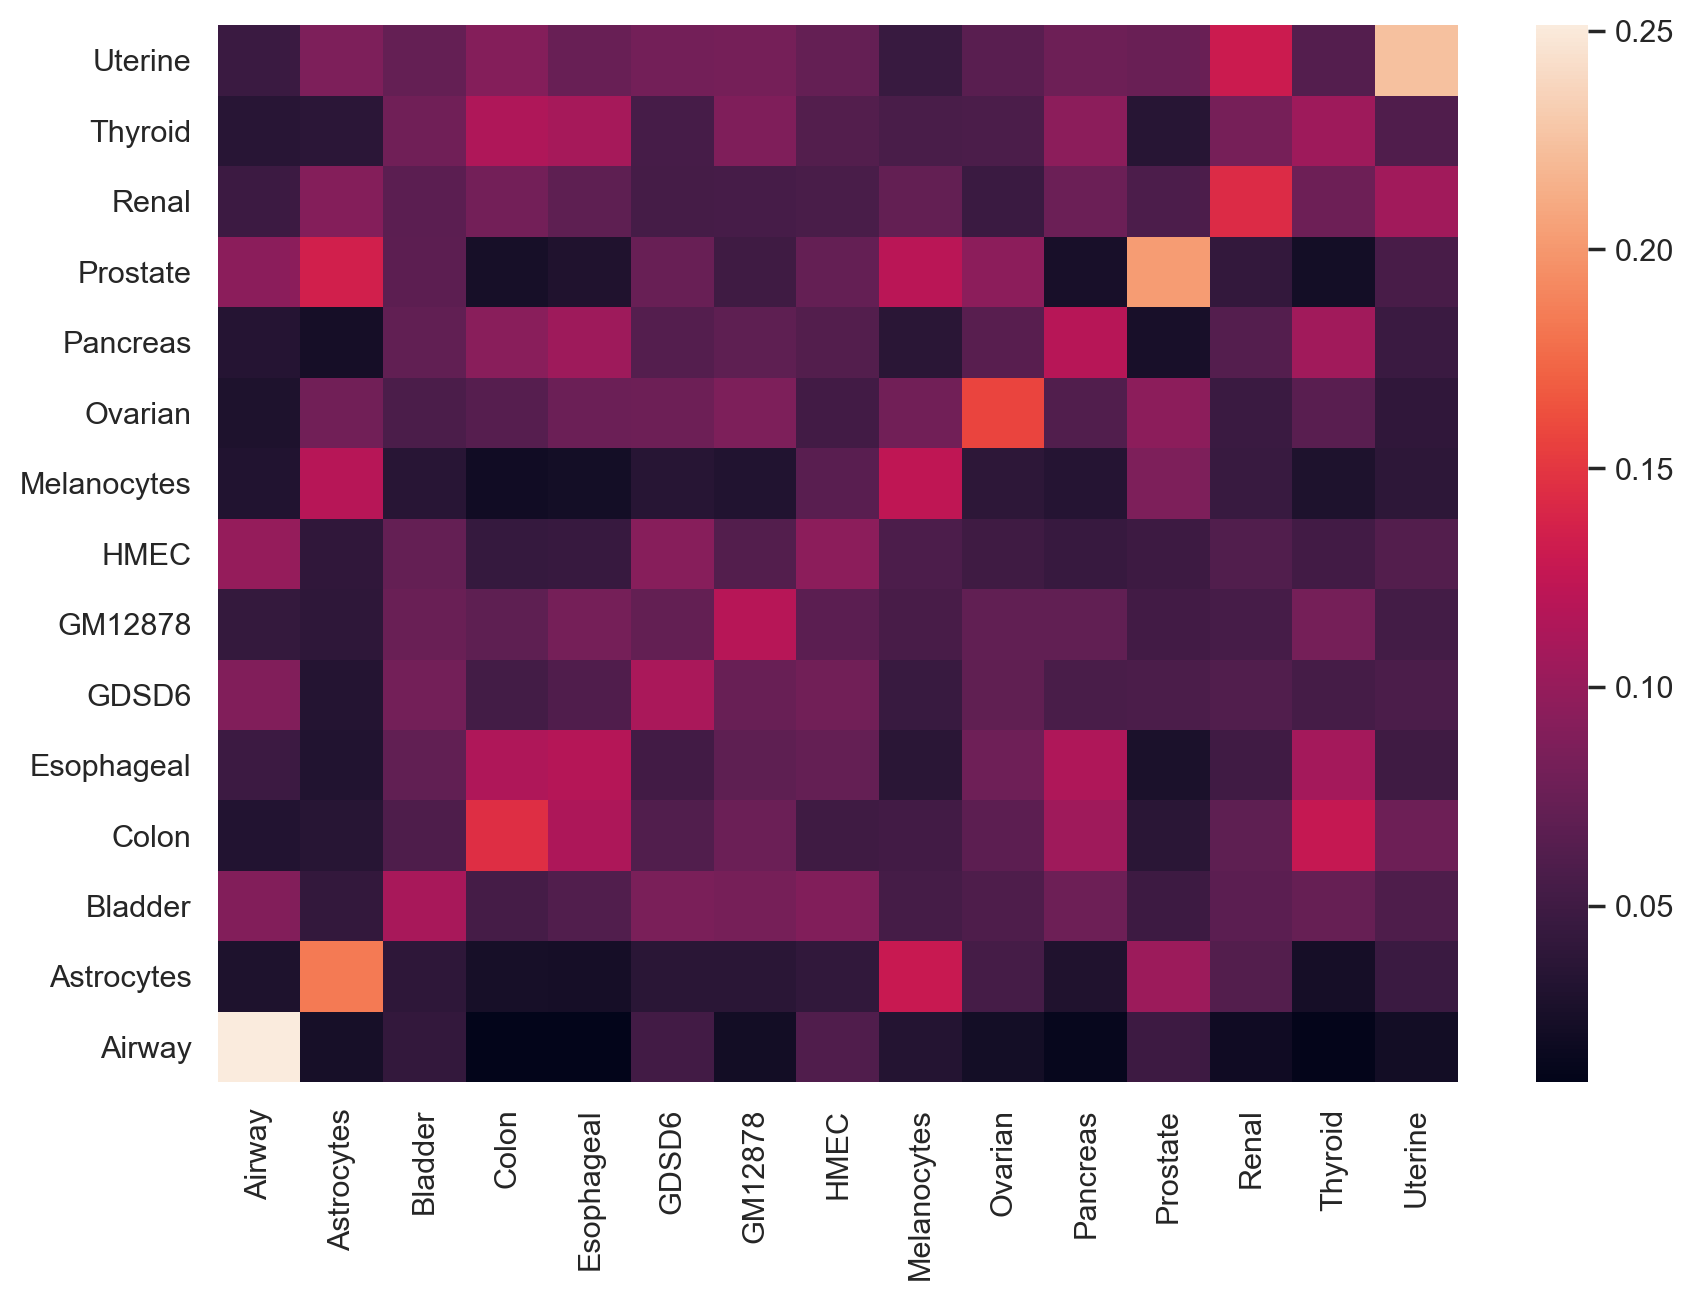

In [127]:
# fig = plt.figure()
fig,ax = plt.subplots(figsize=(10,7),dpi=200)

ax = sns.heatmap(df_confmat/df_confmat.sum(axis=0), annot=False)
ax.set_ylim(0,len(df_confmat))#-0.5, -0.5)
plt.savefig(os.path.join(save_dir, save_prefix + '_df_confmat_ppv.pdf'),pad_inches=0.4)

In [128]:
df_confmat/df_confmat.sum(axis=1)

,Airway,Astrocytes,Bladder,Colon,Esophageal,GDSD6,GM12878,HMEC,Melanocytes,Ovarian,Pancreas,Prostate,Renal,Thyroid,Uterine
Airway,0.374551,0.022739,0.030448,0.010449,0.010656,0.043179,0.015226,0.040766,0.031634,0.019992,0.014499,0.077496,0.017878,0.010700,0.024313
Astrocytes,0.043134,0.174330,0.028273,0.026316,0.025575,0.030317,0.025974,0.027996,0.122437,0.046920,0.031264,0.163934,0.055188,0.022634,0.053679
Bladder,0.132998,0.039919,0.078730,0.057276,0.066496,0.070740,0.059113,0.059921,0.050967,0.051816,0.080652,0.077496,0.059464,0.072016,0.067572
Colon,0.047448,0.032845,0.042627,0.154799,0.121910,0.051447,0.054635,0.033399,0.049209,0.059160,0.110557,0.057377,0.061018,0.125514,0.087780
Esophageal,0.071891,0.029308,0.050457,0.121904,0.126598,0.043179,0.049261,0.049116,0.034564,0.068135,0.118713,0.042474,0.045084,0.106996,0.056205
GDSD6,0.131560,0.030824,0.057851,0.056115,0.064791,0.093248,0.052844,0.054028,0.043937,0.060792,0.058450,0.090537,0.054800,0.053086,0.065046
GM12878,0.063983,0.037393,0.053936,0.073142,0.088662,0.059715,0.084639,0.045187,0.052724,0.062016,0.073856,0.082340,0.048970,0.080247,0.060309
HMEC,0.148814,0.037898,0.051762,0.047214,0.048593,0.077170,0.044335,0.064342,0.055653,0.043656,0.046670,0.077496,0.054411,0.051029,0.070729
Melanocytes,0.046010,0.112683,0.025663,0.021672,0.024723,0.028939,0.021944,0.044695,0.117165,0.033864,0.034889,0.137481,0.041197,0.028807,0.043890
Ovarian,0.043134,0.076301,0.041322,0.068885,0.082694,0.064768,0.061800,0.034872,0.076157,0.137495,0.063888,0.150522,0.042363,0.064609,0.045785


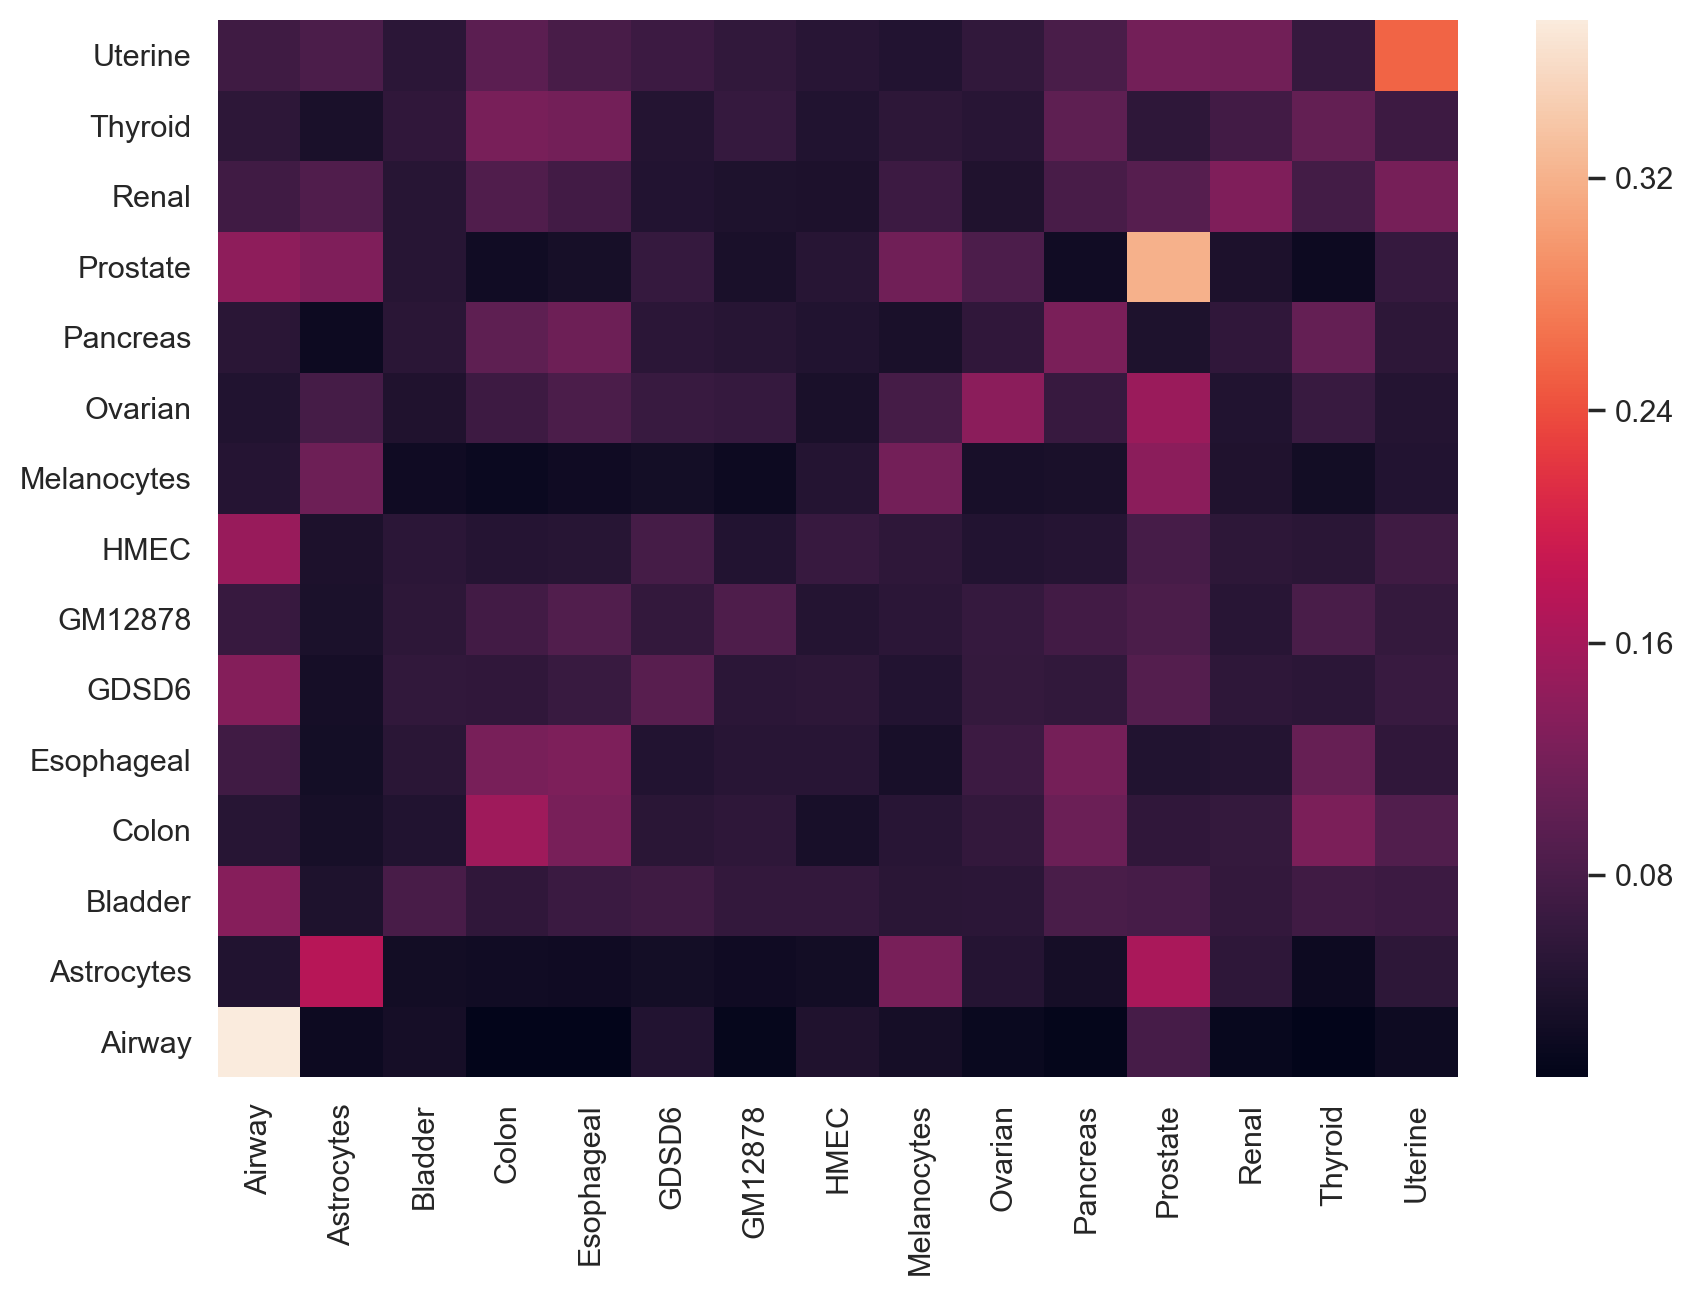

In [129]:
# fig = plt.figure()
fig,ax = plt.subplots(figsize=(10,7),dpi=200)

ax = sns.heatmap(df_confmat/df_confmat.sum(axis=1), annot=False)
ax.set_ylim(0,len(df_confmat))#-0.5, -0.5)
plt.savefig(os.path.join(save_dir, save_prefix + '_df_confmat_sens.pdf'),pad_inches=0.4)

### 2A.1 - testing amount of data



In [130]:
# def test_data_amt(data_mat, label_arr, perc_acc, )

In [131]:
%%time
tot_data = len(data_all_norm)
roc_arr = []
perc_arr = [0.005,0.01,0.02,0.04,0.08,0.16,0.25, 0.32,0.5,0.75,1]
for perc_data in perc_arr:
    chosen_data_len = int(tot_data*perc_data)
    chosen_data_idx = np.random.choice(range(tot_data),chosen_data_len,replace=False)
    train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm[chosen_data_idx,:], 
                                                                                tissue_labels[chosen_data_idx],
                                                                             test_size = 0.25, random_state = 80)
    model = RandomForestClassifier(n_estimators=200, 
                               max_features = 'sqrt',
                                
                               n_jobs=-1, verbose = 0)
    # Fit on training data
    model.fit(train_features, train_labels)
    # Actual class predictions
    rf_predictions = model.predict(test_features)
    # Probabilities for each class
    rf_probs = model.predict_proba(test_features)
    try:
        # # Calculate roc auc
        roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
    except:
        roc_value = .5
    roc_arr.append(roc_value)
    print(perc_data,chosen_data_len, roc_value)


0.005 685 0.5954396480088779
0.01 1370 0.5860568691770346
0.02 2741 0.6220430374083724
0.04 5482 0.6315592803397082
0.08 10964 0.6377876414531323
0.16 21928 0.6425835438540953
0.25 34263 0.6592770198957627
0.32 43857 0.6552085605761006
0.5 68527 0.6620059997177951
0.75 102790 0.6661412667654483
1 137054 0.6678918886997861
CPU times: user 3min 12s, sys: 13.1 s, total: 3min 25s
Wall time: 22.4 s


In [132]:
eval_df = pd.DataFrame.from_dict({'perc':perc_arr,'auc': roc_arr},orient='columns')
eval_df.to_csv(os.path.join(save_dir, save_prefix+'_eval_df.csv'))

# for joining multiple eval metrics

In [7]:
glob.glob(os.path.join(save_dir, '*eval_df.csv'))

['../data/processed/fig4_modelling/pro_tf_only_random_eval_df.csv',
 '../data/processed/fig4_modelling/comb_no_tf_eval_df.csv',
 '../data/processed/fig4_modelling/dist_tf_only_eval_df.csv',
 '../data/processed/fig4_modelling/comb_tf_only_eval_df.csv',
 '../data/processed/fig4_modelling/comb_tf_only_random_eval_df.csv',
 '../data/processed/fig4_modelling/pro_no_tf_eval_df.csv',
 '../data/processed/fig4_modelling/proxall_tf_only_eval_df.csv',
 '../data/processed/fig4_modelling/prom_tf_only_eval_df.csv',
 '../data/processed/fig4_modelling/sum_tf_only_eval_df.csv',
 '../data/processed/fig4_modelling/dist_tf_only_random_eval_df.csv',
 '../data/processed/fig4_modelling/pro_dist_sum_tf_only_eval_df.csv',
 '../data/processed/fig4_modelling/pro_dist_sep_tf_only_eval_df.csv',
 '../data/processed/fig4_modelling/pro_dist_sum_all_eval_df.csv',
 '../data/processed/fig4_modelling/dist_all_eval_df.csv',
 '../data/processed/fig4_modelling/comb_all_eval_df.csv']

pro_tf_only_random
comb_no_tf


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


dist_tf_only
comb_tf_only
comb_tf_only_random
pro_no_tf
proxall_tf_only
prom_tf_only
sum_tf_only
dist_tf_only_random
pro_dist_sum_tf_only
pro_dist_sep_tf_only
pro_dist_sum_all
dist_all
comb_all


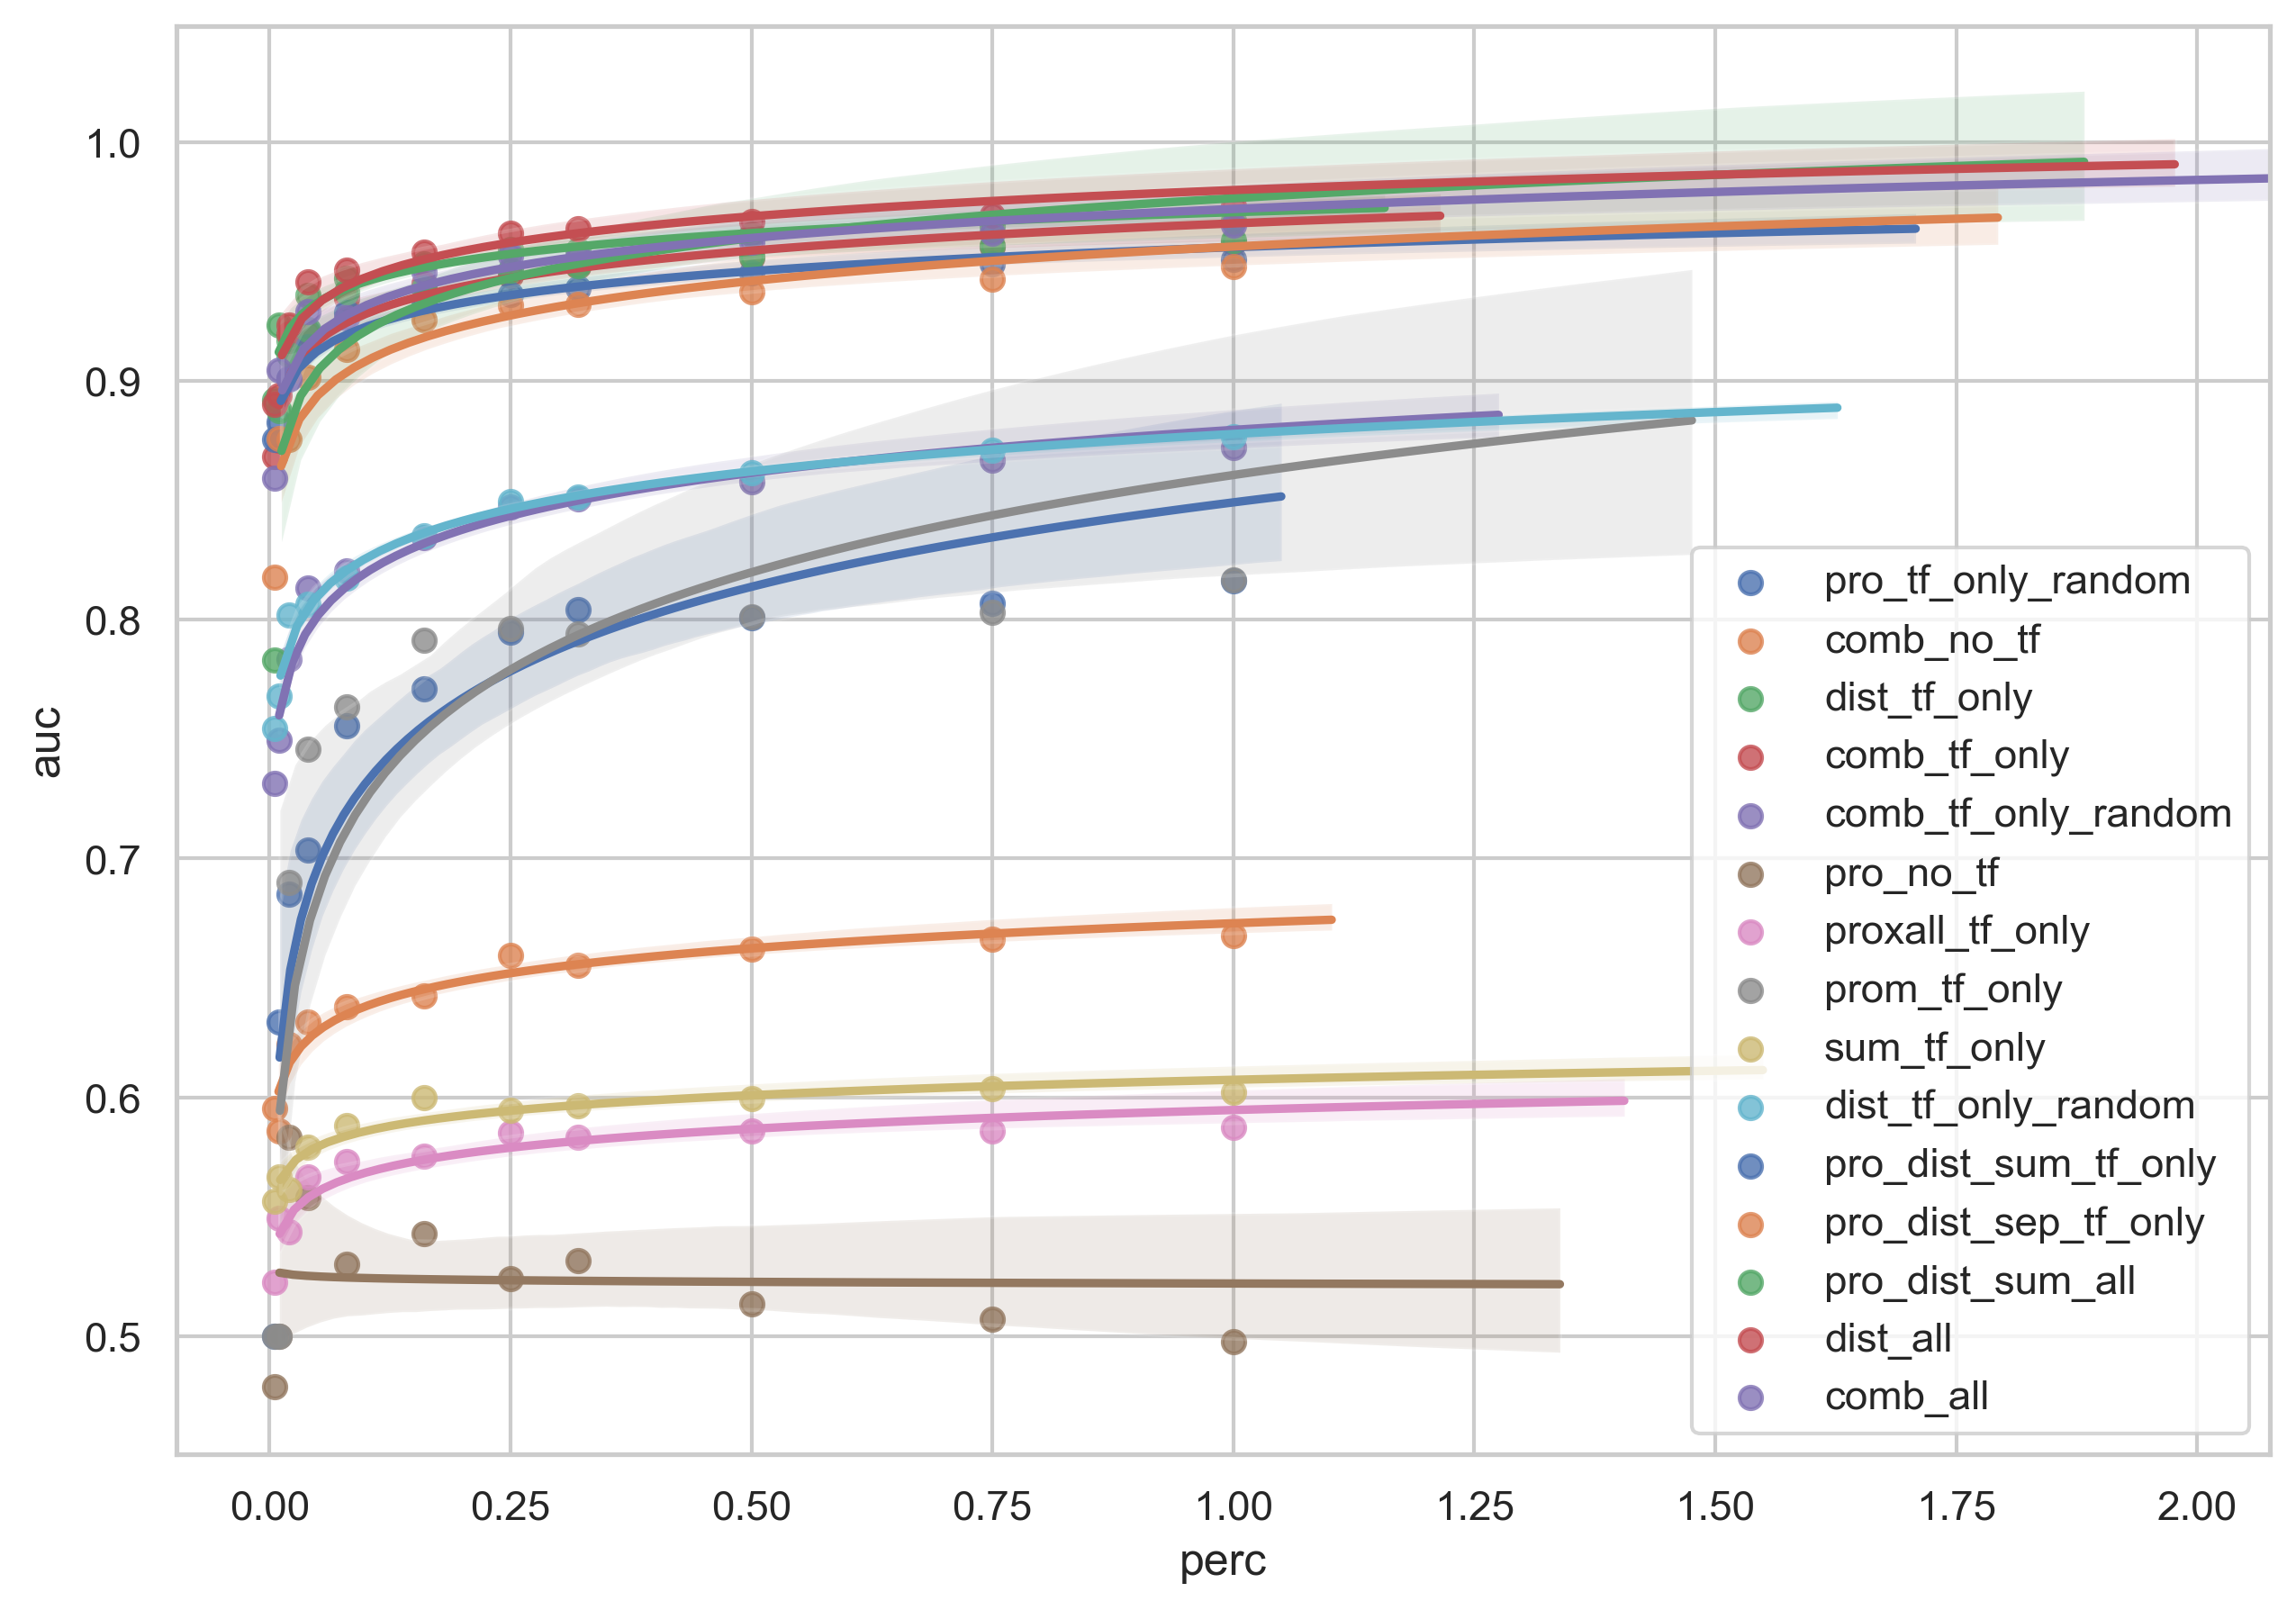

In [22]:
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
# type_to_legend_mapping = {
#     'sep':a
# }
for filepath in glob.glob(os.path.join(save_dir, '*eval_df.csv')):
    filename = os.path.basename(filepath)
    type_data = filename.split('_eval')[0]
    print(type_data)
    eval_df = pd.read_csv(filepath)
    sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label=type_data)
ax.legend()
fig.savefig(os.path.join(save_dir, 'all_eval_data_type.pdf'))

what this plot shows is that cell type specificity is driven by the cell type specific looped regions to the TSS . Promoter region (within 2kb upsteam and 5bp downstream of TSS) yields max AUC of ~80% (`prom_tf_only`), but when using proximal anchor regions to the TSS, auc decreases to ~60% (`proxall_tf_only` and `sum_tf_only`).Moreover, there seems to be very minimal difference in model performance when we look at only distal regions or also consider proximal regions (`comb_tf_only`, `pro_dist_sep_tf_only` and `pro_dist_sum_tf_only` perform slightly less well than `dist_tf_only`, similarly, `dist_all` is slightly better than `comb_all`).  This seems to indicate cell type specific looping drives much of our tf regulation based understanding of cell type specificity.

moreover, tf information by itself seems to be sufficient for maximizing understanding. While `exp` 
 and that promoter region only show s some 

to plot fo main figure:


1. HiChIP+ATAC+RNA+TF 'comb_all',
2. HiCHIP+ATAC+RNA 'comb_no_tf'
3. HiChIP(distal only)+ATAC+RNA+TF, 'dist_all'
4. ATAC+RNA+TF, prom_tf_only,
5. ATAC+RNA

comb_tf_only
comb_no_tf


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


dist_tf_only
prom_tf_only
pro_no_tf


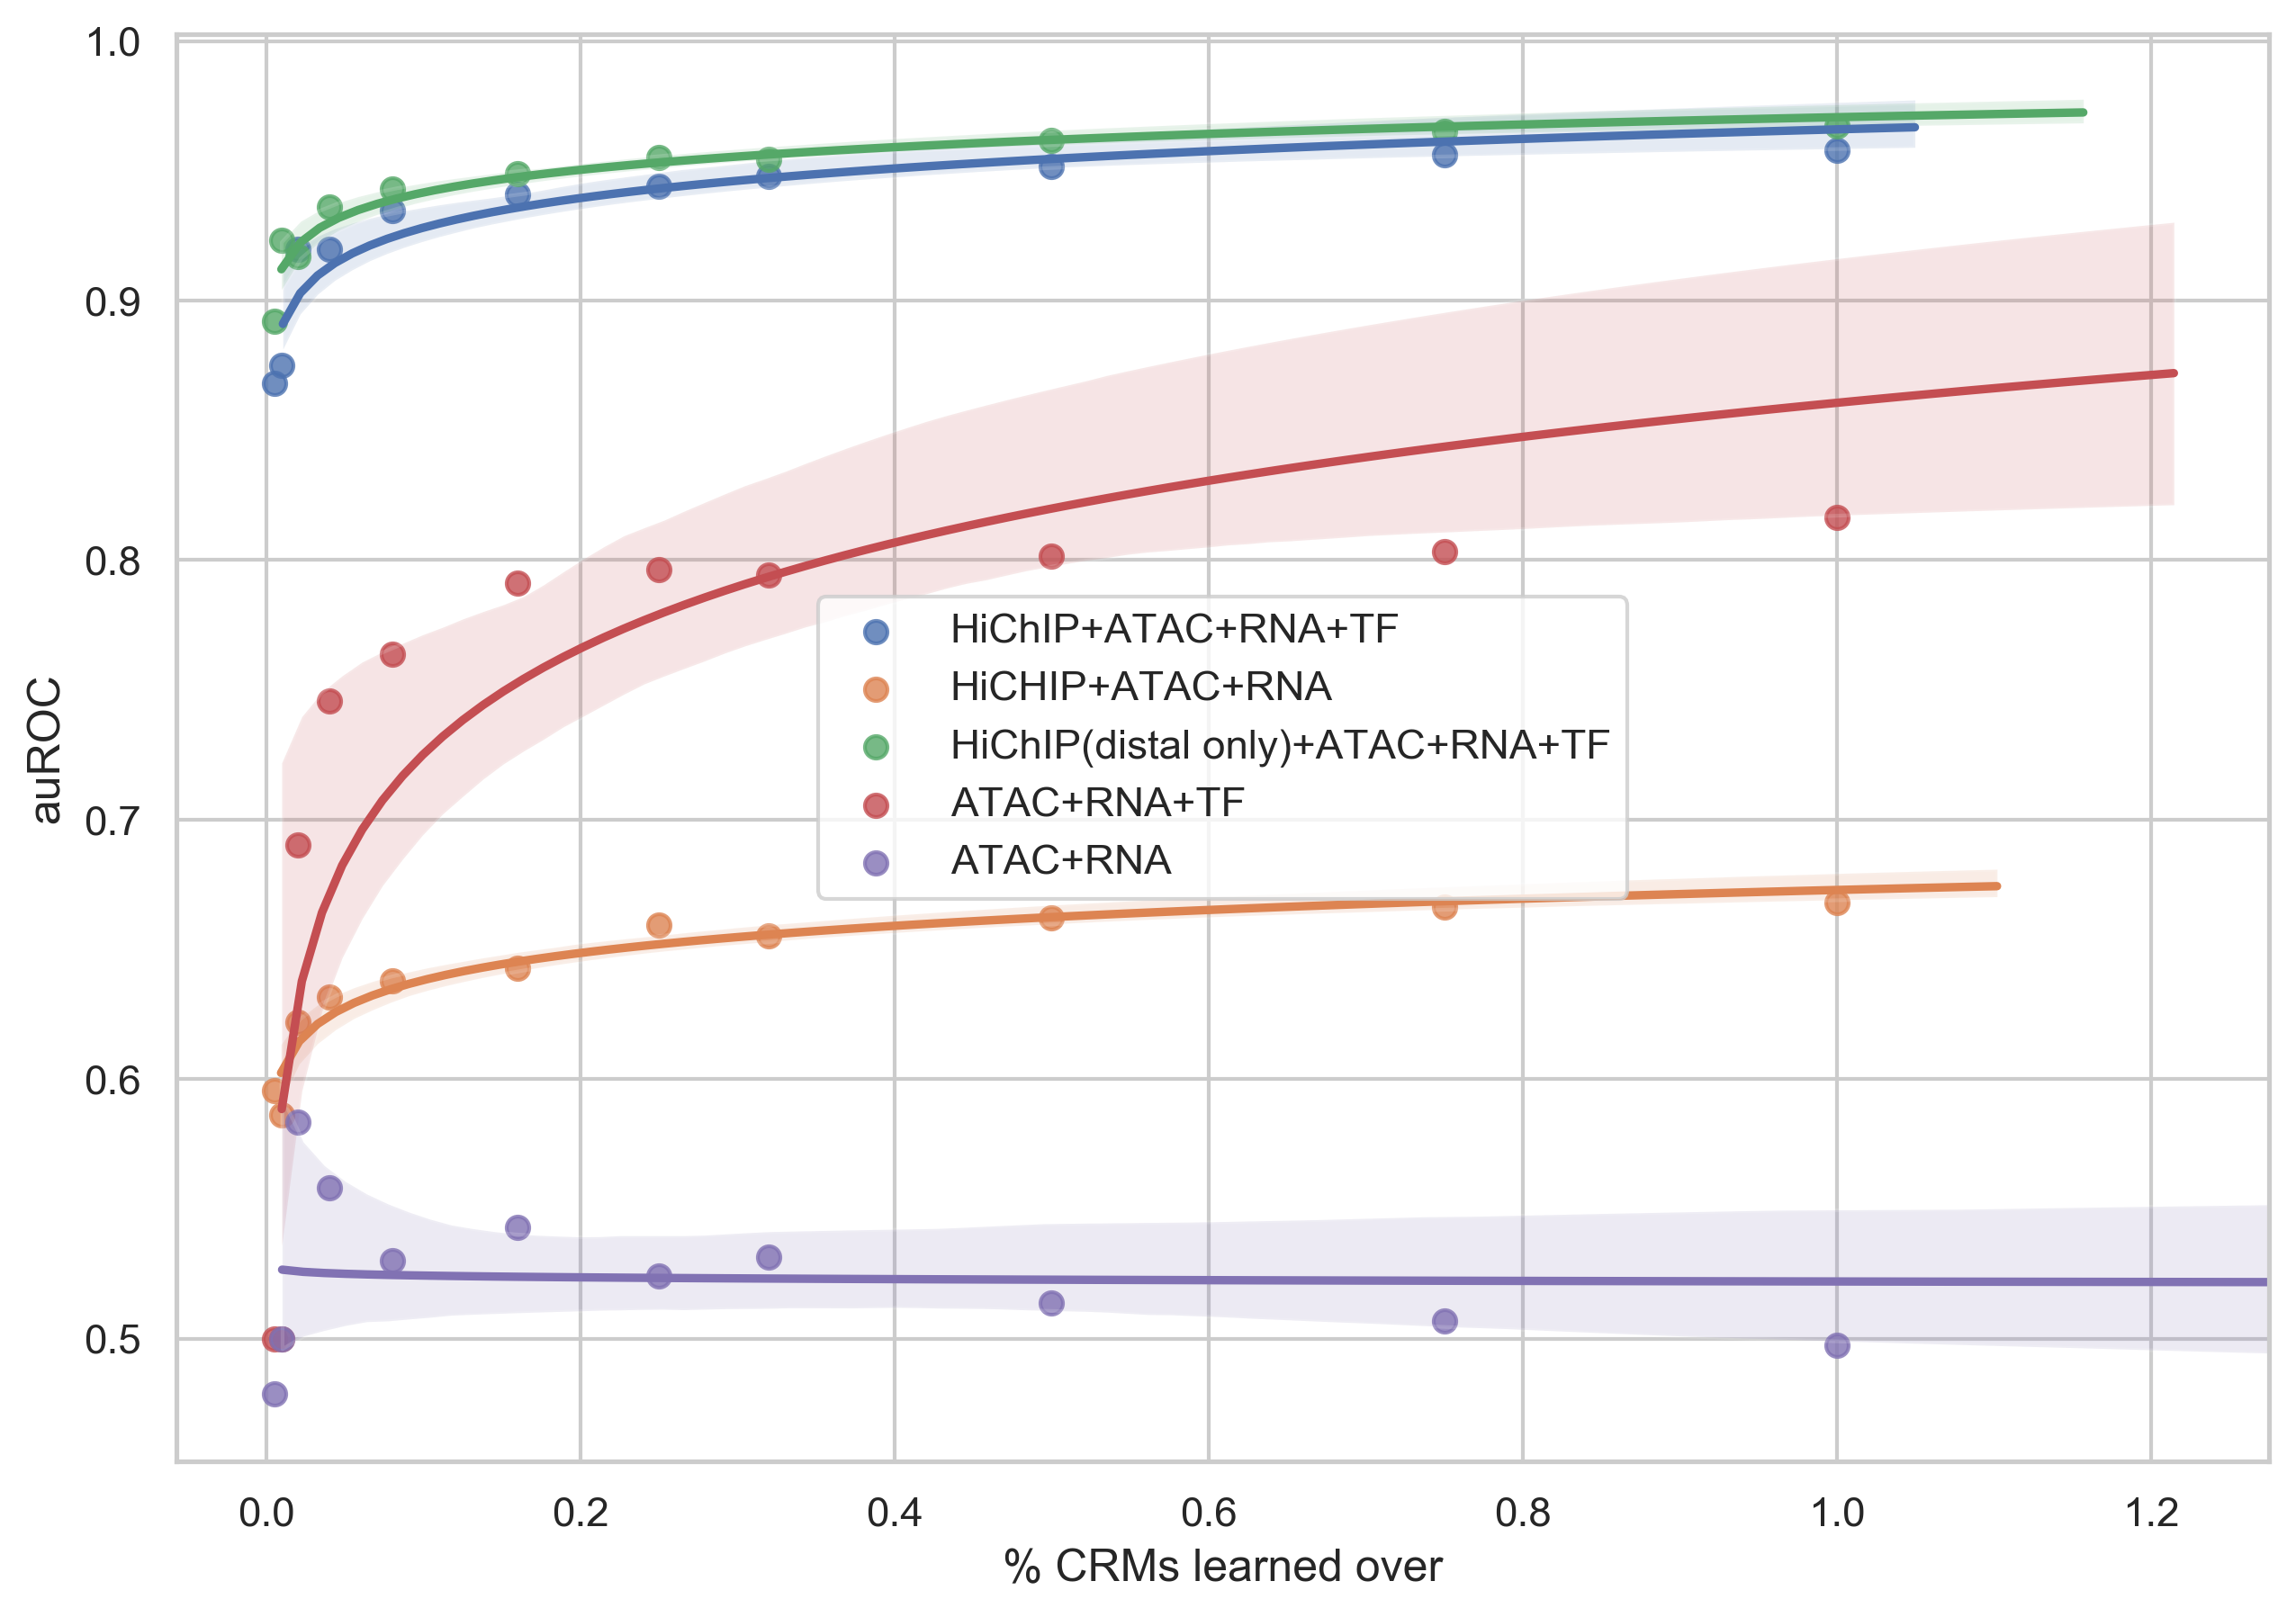

In [32]:
selected_types=['comb_tf_only', 'comb_no_tf', 'dist_tf_only', 'prom_tf_only', 'pro_no_tf']

# 'proxall_tf_only', 'prom_tf_only', 
                #'sum_tf_only', 'pro_dist_sum_tf_only', 
#                 'pro_dist_sep_tf_only', 'pro_dist_sum_all',
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
labels=['HiChIP+ATAC+RNA+TF',
                  'HiCHIP+ATAC+RNA',
                  'HiChIP(distal only)+ATAC+RNA+TF',
                 'ATAC+RNA+TF','ATAC+RNA']

for type_data,type_data_str in zip(selected_types, labels):
    print(type_data)
    filepath = os.path.join(save_dir, type_data+'_eval_df.csv')
    filename = os.path.basename(filepath)
    eval_df = pd.read_csv(filepath)
    sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label=type_data_str)
ax.legend()
ax.set_xlabel('% CRMs learned over')
ax.set_ylabel('auROC')
fig.savefig(os.path.join(save_dir, 'all_eval_data_type_selected_comb_dist_pro.pdf'))

dist_tf_only
comb_tf_only


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


proxall_tf_only
prom_tf_only


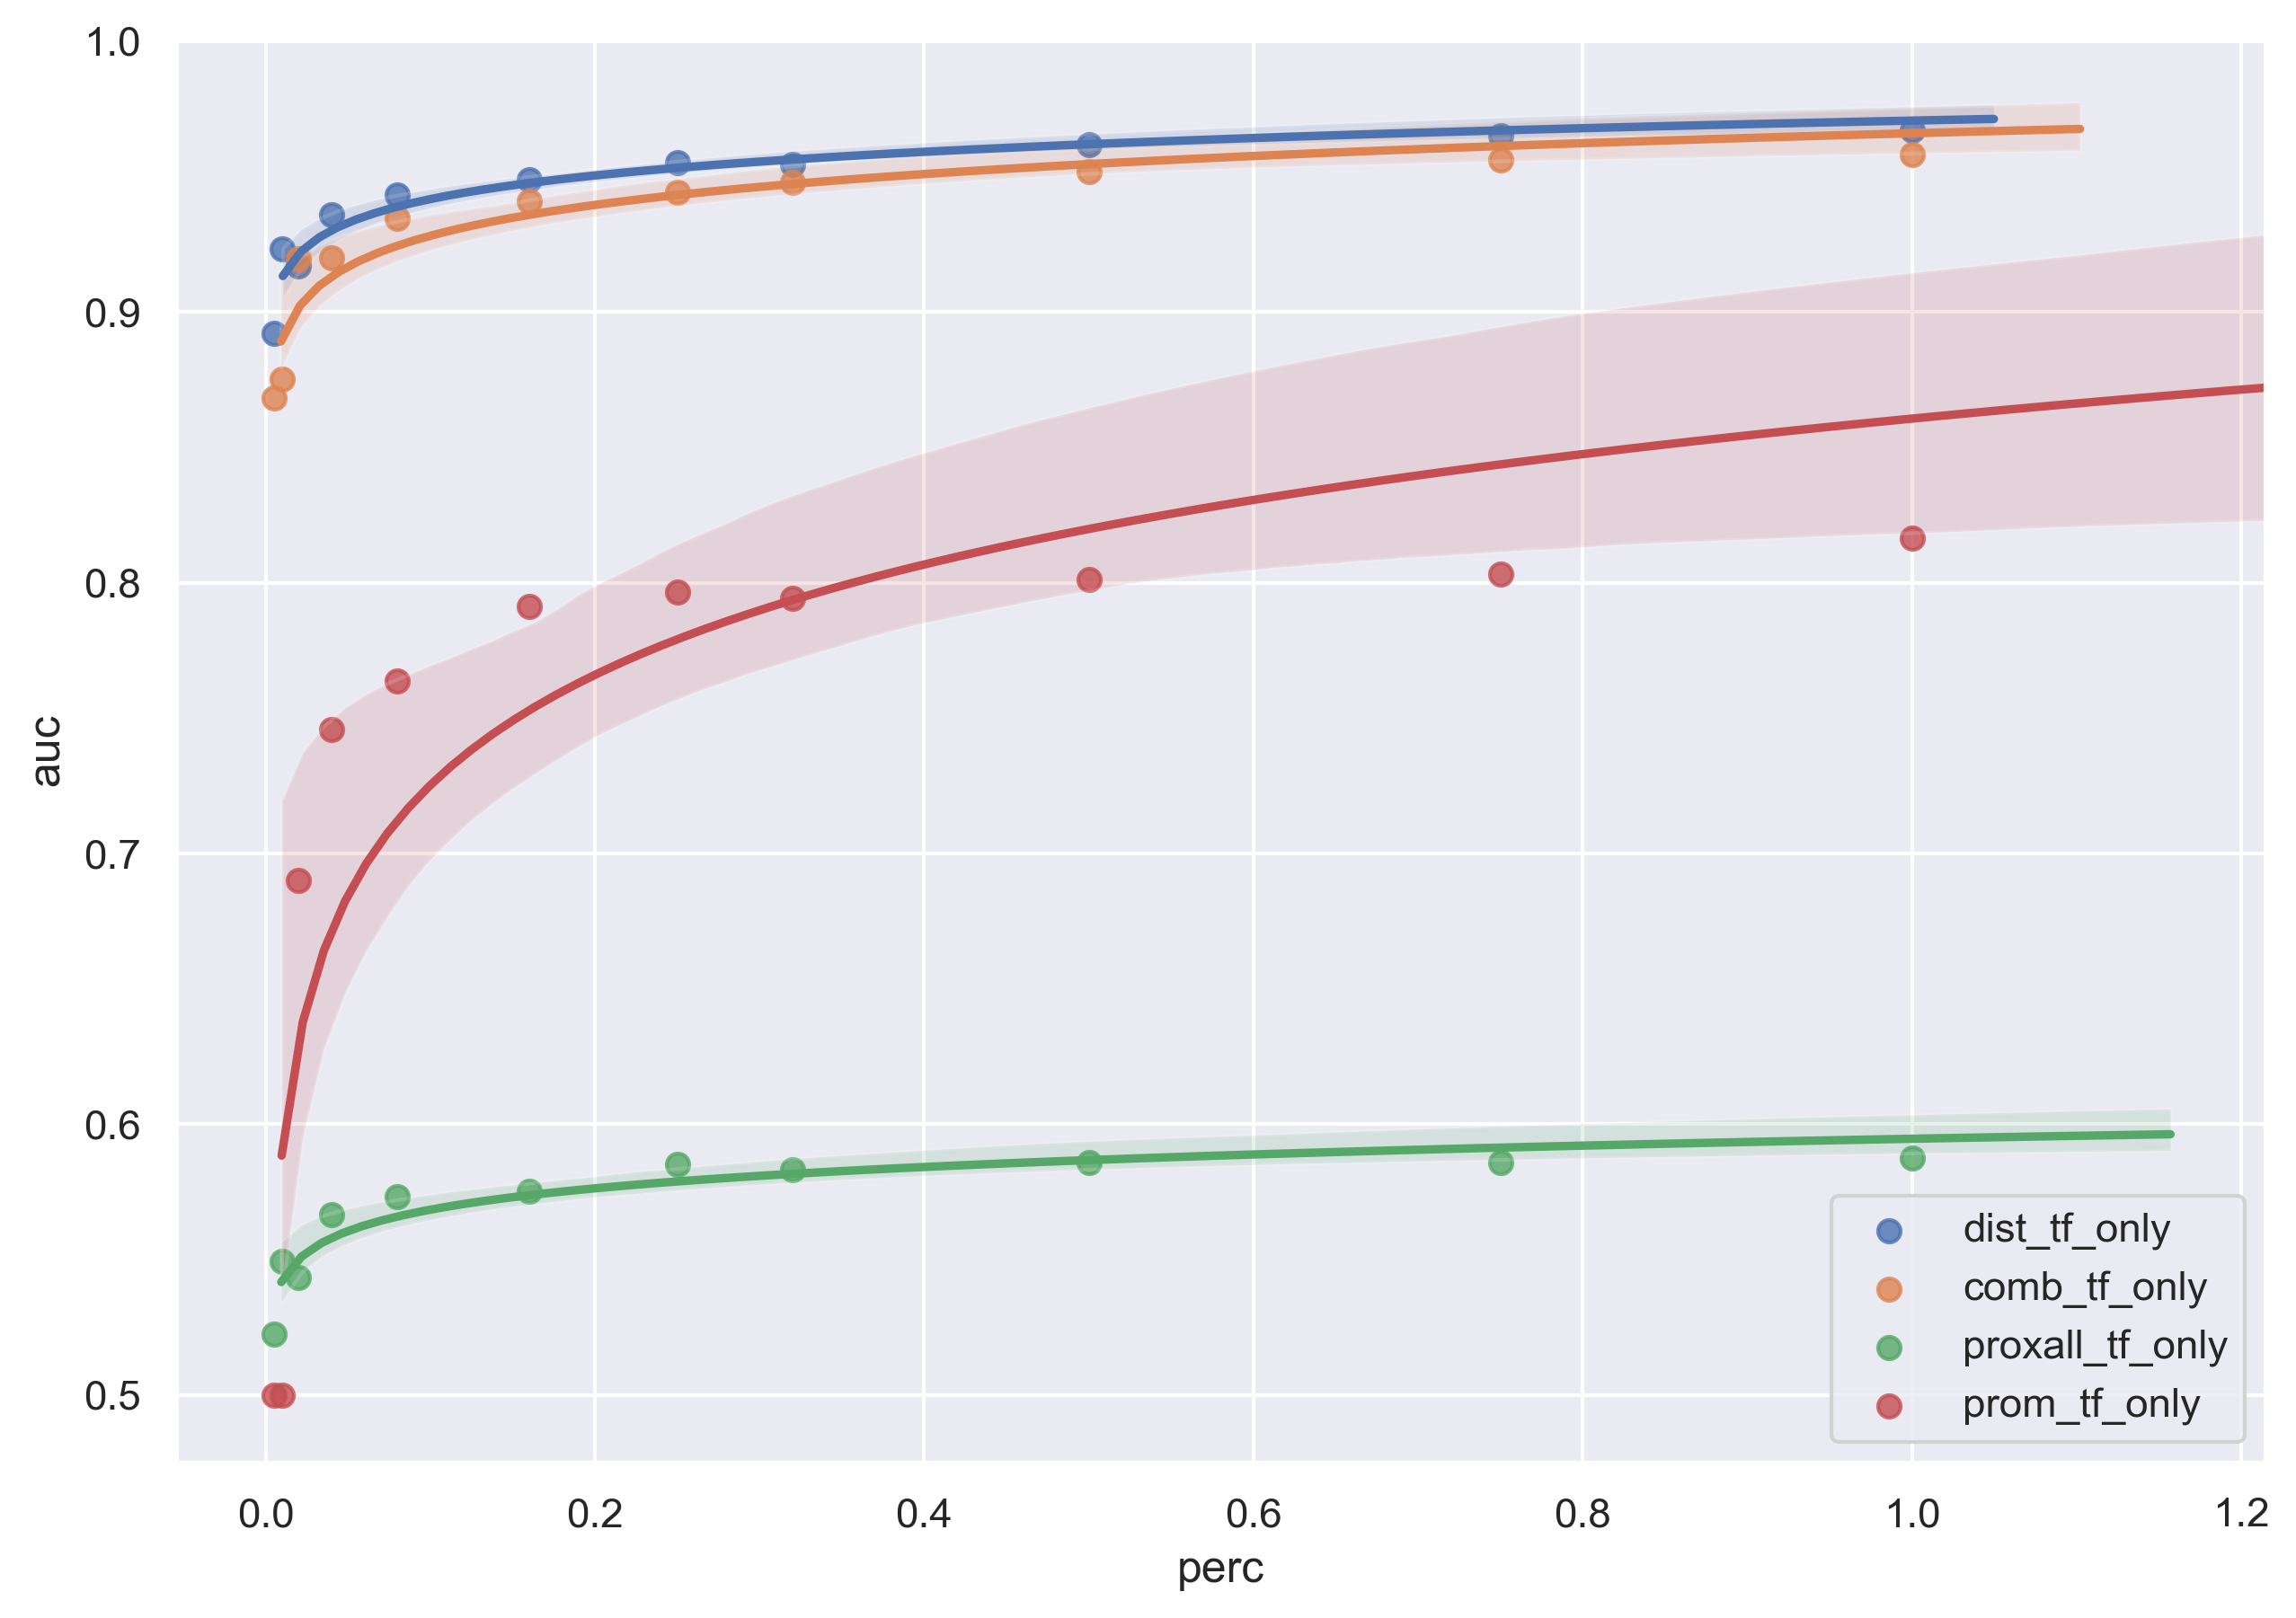

In [142]:
selected_types=['dist_tf_only', 'comb_tf_only', 'prom_tf_only', 'proxall_tf_only']

# 'proxall_tf_only', 'prom_tf_only', 
                #'sum_tf_only', 'pro_dist_sum_tf_only', 
#                 'pro_dist_sep_tf_only', 'pro_dist_sum_all',
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)

for filepath in glob.glob(os.path.join(save_dir, '*eval_df.csv')):
    filename = os.path.basename(filepath)
    type_data = filename.split('_eval')[0]
    if type_data in selected_types:
        print(type_data)
        eval_df = pd.read_csv(filepath)
        sns.regplot(x="perc", y="auc",data=eval_df,
               logx=True,ax=ax,label=type_data)
ax.legend()
fig.savefig(os.path.join(save_dir, 'all_eval_data_type_selected_dist_pro.pdf'))

dist_tf_only
comb_tf_only


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


dist_all
comb_all


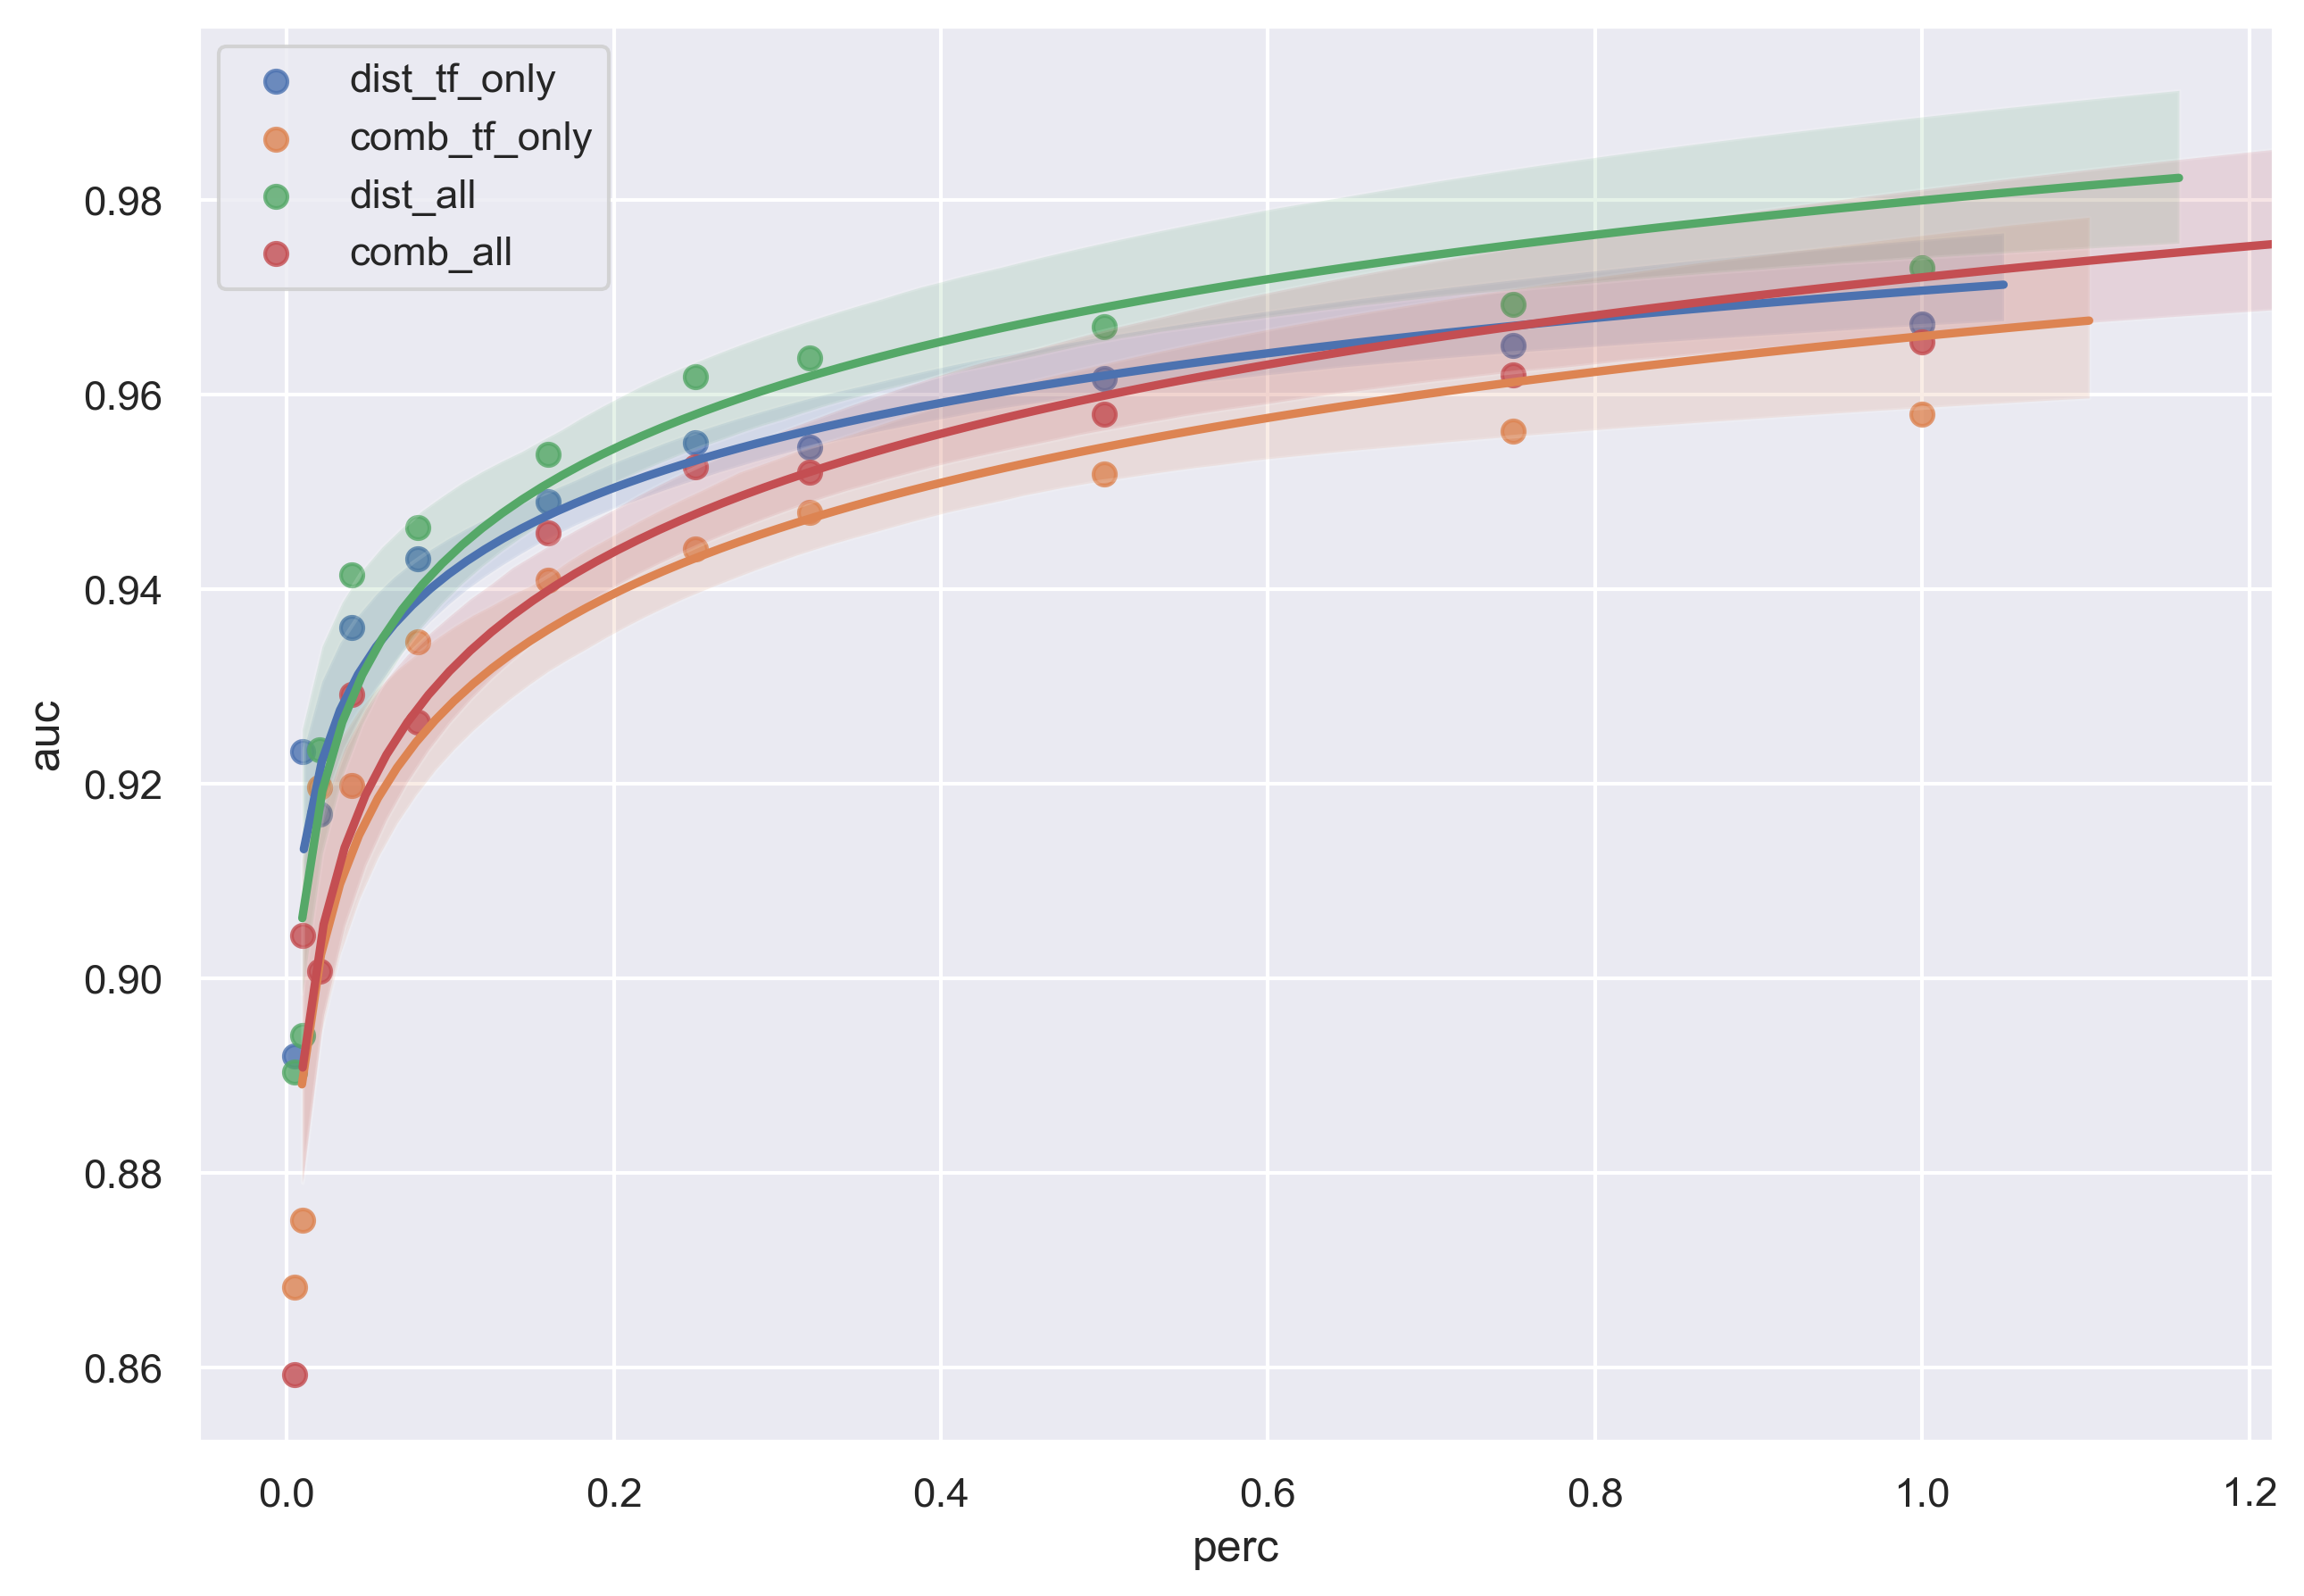

In [143]:
selected_types=['dist_tf_only', 'comb_tf_only',  'dist_all', 'comb_all']

# 'proxall_tf_only', 'prom_tf_only', 
                #'sum_tf_only', 'pro_dist_sum_tf_only', 
#                 'pro_dist_sep_tf_only', 'pro_dist_sum_all',
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)

for filepath in glob.glob(os.path.join(save_dir, '*eval_df.csv')):
    filename = os.path.basename(filepath)
    type_data = filename.split('_eval')[0]
    if type_data in selected_types:
        print(type_data)
        eval_df = pd.read_csv(filepath)
        sns.regplot(x="perc", y="auc",data=eval_df,
               logx=True,ax=ax,label=type_data)
ax.legend()
fig.savefig(os.path.join(save_dir, 'all_eval_data_type_selected_dist.pdf'))

pro_tf_only_random
dist_tf_only


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


prom_tf_only
dist_tf_only_random


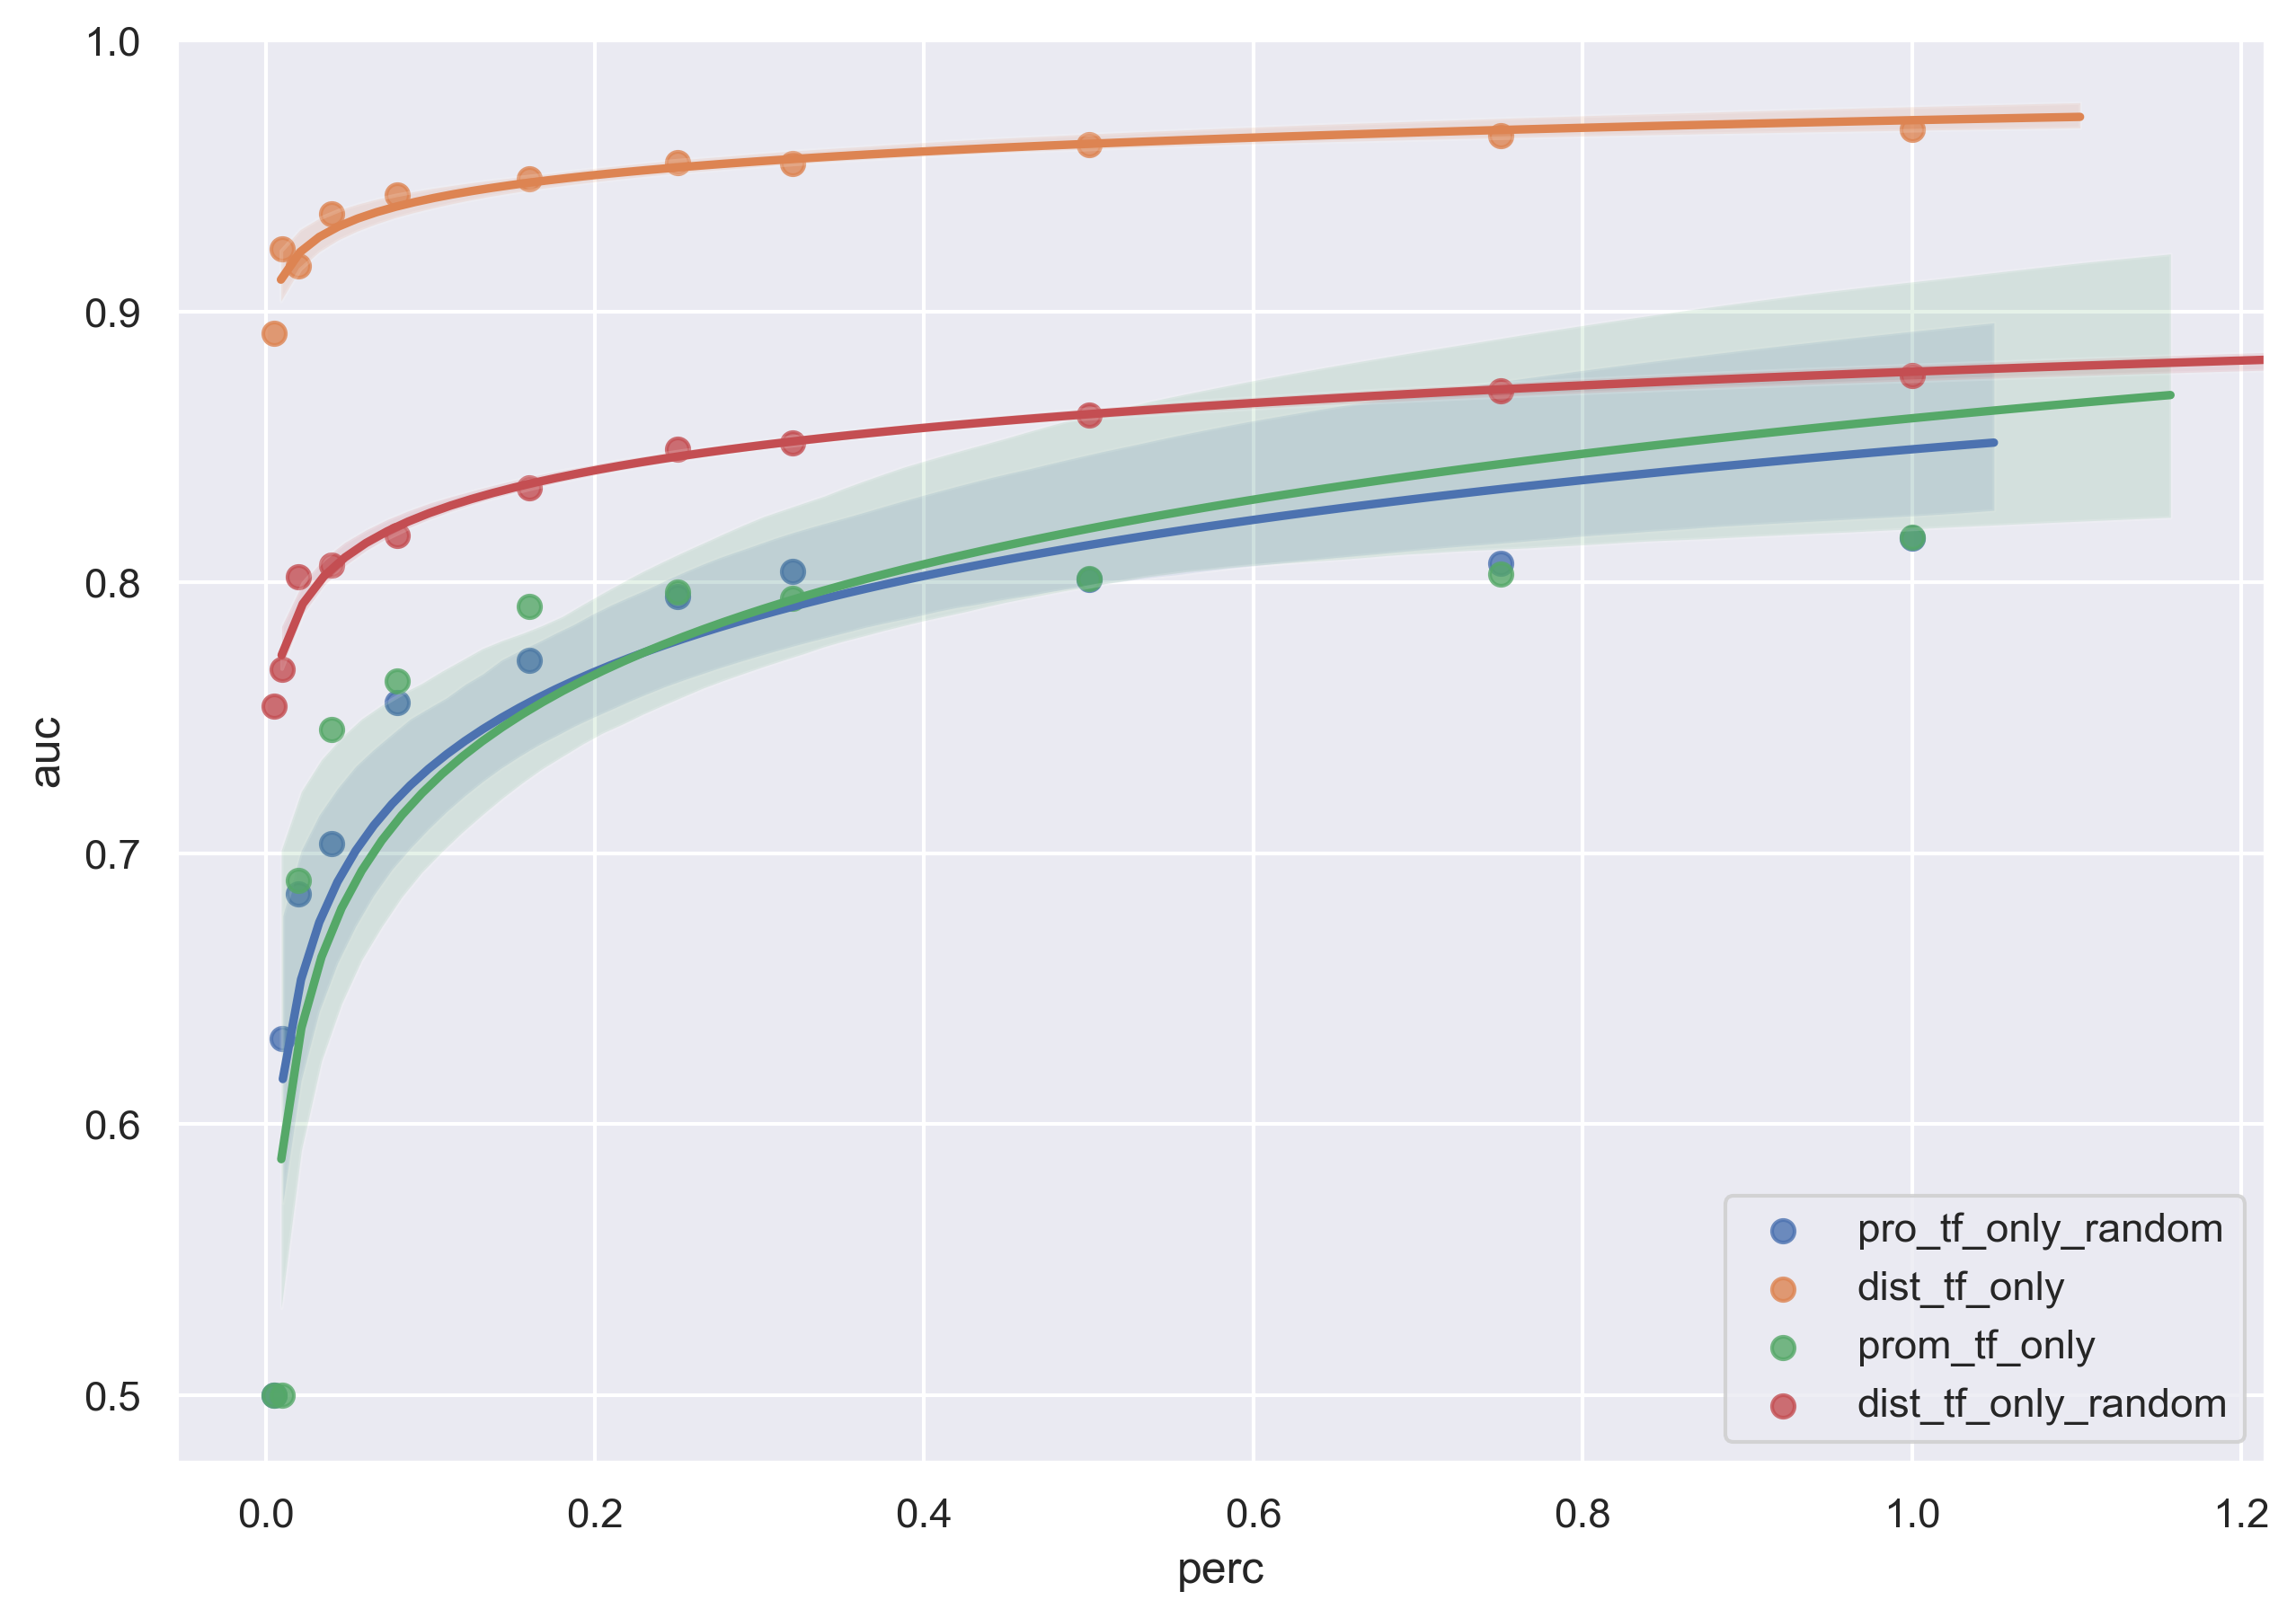

In [200]:
selected_types=['dist_tf_only_random', 'dist_tf_only',  'pro_tf_only_random', 'prom_tf_only']

# 'proxall_tf_only', 'prom_tf_only', 
                #'sum_tf_only', 'pro_dist_sum_tf_only', 
#                 'pro_dist_sep_tf_only', 'pro_dist_sum_all',
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)

for filepath in glob.glob(os.path.join(save_dir, '*eval_df.csv')):
    filename = os.path.basename(filepath)
    type_data = filename.split('_eval')[0]
    if type_data in selected_types:
        print(type_data)
        eval_df = pd.read_csv(filepath)
        sns.regplot(x="perc", y="auc",data=eval_df,
               logx=True,ax=ax,label=type_data)
ax.legend()
fig.savefig(os.path.join(save_dir, 'all_eval_data_type_selected_random_eval.pdf'))

In [ ]:
selected_types=['dist_tf_only', 'comb_tf_only', 'prom_tf_only', 'proxall_tf_only']

# 'proxall_tf_only', 'prom_tf_only', 
                #'sum_tf_only', 'pro_dist_sum_tf_only', 
#                 'pro_dist_sep_tf_only', 'pro_dist_sum_all',
fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)

for filepath in glob.glob(os.path.join(save_dir, '*eval_df.csv')):
    filename = os.path.basename(filepath)
    type_data = filename.split('_eval')[0]
    if type_data in selected_types:
        print(type_data)
        eval_df = pd.read_csv(filepath)
        sns.regplot(x="perc", y="auc",data=eval_df,
               logx=True,ax=ax,label=type_data)
ax.legend()
fig.savefig(os.path.join(save_dir, 'all_eval_data_type_selected_dist_pro.pdf'))

wider search region, 

note that we are deliberately overfitting to the best possible model. Aka we only consider when there are data features present (there is at least 1 tf present in looped. The more random the loops the more random the regions 
- difference between dist_tf_only and dist_tf_only_random represents the gain by being accurate with looping information
- difference between prom_tf_only_random and dist_tf_only_random, represents the added benefit of screening for more area (5kb ++ increase)
- the lack of difference between pro_tf_only_random and prom_tf_only, is because the promoter region isn't very random (which checks out). 


In [ ]:

data_chosen

In [ ]:
# # %%time
# # rna info only
# tot_data = len(data_all_norm)
# column_chosen =[0,data_all_norm.shape[1]-1] # exp, num_gene
# roc_arr = []
# perc_arr = [0.005,0.01,0.02,0.04,0.08,0.16,0.25, 0.32,0.5,0.75,1]
# for perc_data in perc_arr:
#     chosen_data_len = int(tot_data*perc_data)
#     chosen_data_idx = np.random.choice(range(tot_data),chosen_data_len,replace=False)
#     data_chosen = data_all_norm[chosen_data_idx,:]
#     data_chosen = data_chosen[:,column_chosen].reshape((chosen_data_len, len(column_chosen)))

#     train_features, test_features, train_labels, test_labels = train_test_split(data_chosen, 
#                                                                                 tissue_labels[chosen_data_idx],
#                                                                              test_size = 0.25, random_state = 80)
#     model = RandomForestClassifier(n_estimators=200, 
#                                max_features = 'sqrt',
#                                n_jobs=-1, verbose = 0)
#     # Fit on training data
#     model.fit(train_features, train_labels)
#     # Actual class predictions
#     rf_predictions = model.predict(test_features)
#     # Probabilities for each class
#     rf_probs = model.predict_proba(test_features)
#     try:
#         # # Calculate roc auc
#         roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
#     except:
#         roc_value = .5
#     roc_arr.append(roc_value)
#     print(perc_data,chosen_data_len, roc_value)
# eval_df = pd.DataFrame.from_dict({'perc':perc_arr,'auc': roc_arr},orient='columns')
# eval_df.to_csv(os.path.join(save_dir, 'rna_eval_df.csv'))

In [82]:
eval_df

,perc,auc
0,0.005,0.868275
1,0.010,0.875121
2,0.020,0.919623
3,0.040,0.919857
4,0.080,0.934553
5,0.160,0.940883
6,0.250,0.944169
7,0.320,0.947855
8,0.500,0.951863
9,0.750,0.956203


fig = plt.figure(figsize=(10,7),dpi=300)
ax = plt.subplot(111)
sns.regplot(x="perc", y="auc",data=eval_df,
           logx=True,ax=ax,label='tf_with_hichip')

In [7]:
# # sns.lineplot(x="perc", y="roc", data= pd.DataFrame.from_dict({'perc':perc_arr, 'roc':roc_arr}, orient='columns'))

# comb_eval_df = pd.read_csv(os.path.join(save_dir, 'comb_tf_only_eval_df.csv'))
# prom_eval_df = pd.read_csv(os.path.join(save_dir, 'prom_tf_only_eval_df.csv'))

# fig = plt.figure(figsize=(10,7),dpi=300)
# ax = plt.subplot(111)
# sns.regplot(x="perc", y="auc",data=comb_eval_df,
#            logx=True,ax=ax,label='with looping')
# sns.regplot(x="perc", y="auc",data=prom_eval_df,
#            logx=True,ax=ax,color='darkred',label='no looping')
# ax.legend()
# ax.set_xlabel('% of data')
# fig.savefig(os.path.join(save_dir, '6A_eval_data_type_looping.pdf'))

In [8]:
glob.glob(os.path.join(save_dir, '*values.csv'))

['../data/processed/fig4_modelling/dist_tf_only_auc_curve_values.csv',
 '../data/processed/fig4_modelling/comb_all_auc_curve_values.csv',
 '../data/processed/fig4_modelling/proxall_tf_only_auc_curve_values.csv',
 '../data/processed/fig4_modelling/comb_tf_only_auc_curve_values.csv',
 '../data/processed/fig4_modelling/comb_tf_only_allcrms_auc_curve_values.csv',
 '../data/processed/fig4_modelling/dist_random_tf_only_auc_curve_values.csv',
 '../data/processed/fig4_modelling/prom_tf_only_auc_curve_values.csv',
 '../data/processed/fig4_modelling/pro_dist_sep_tf_only_auc_curve_values.csv',
 '../data/processed/fig4_modelling/sum_tf_only_auc_curve_values.csv',
 '../data/processed/fig4_modelling/pro_dist_sum_tf_only_auc_curve_values.csv',
 '../data/processed/fig4_modelling/pro_dist_sum_all_auc_curve_values.csv']

(6156, 3)


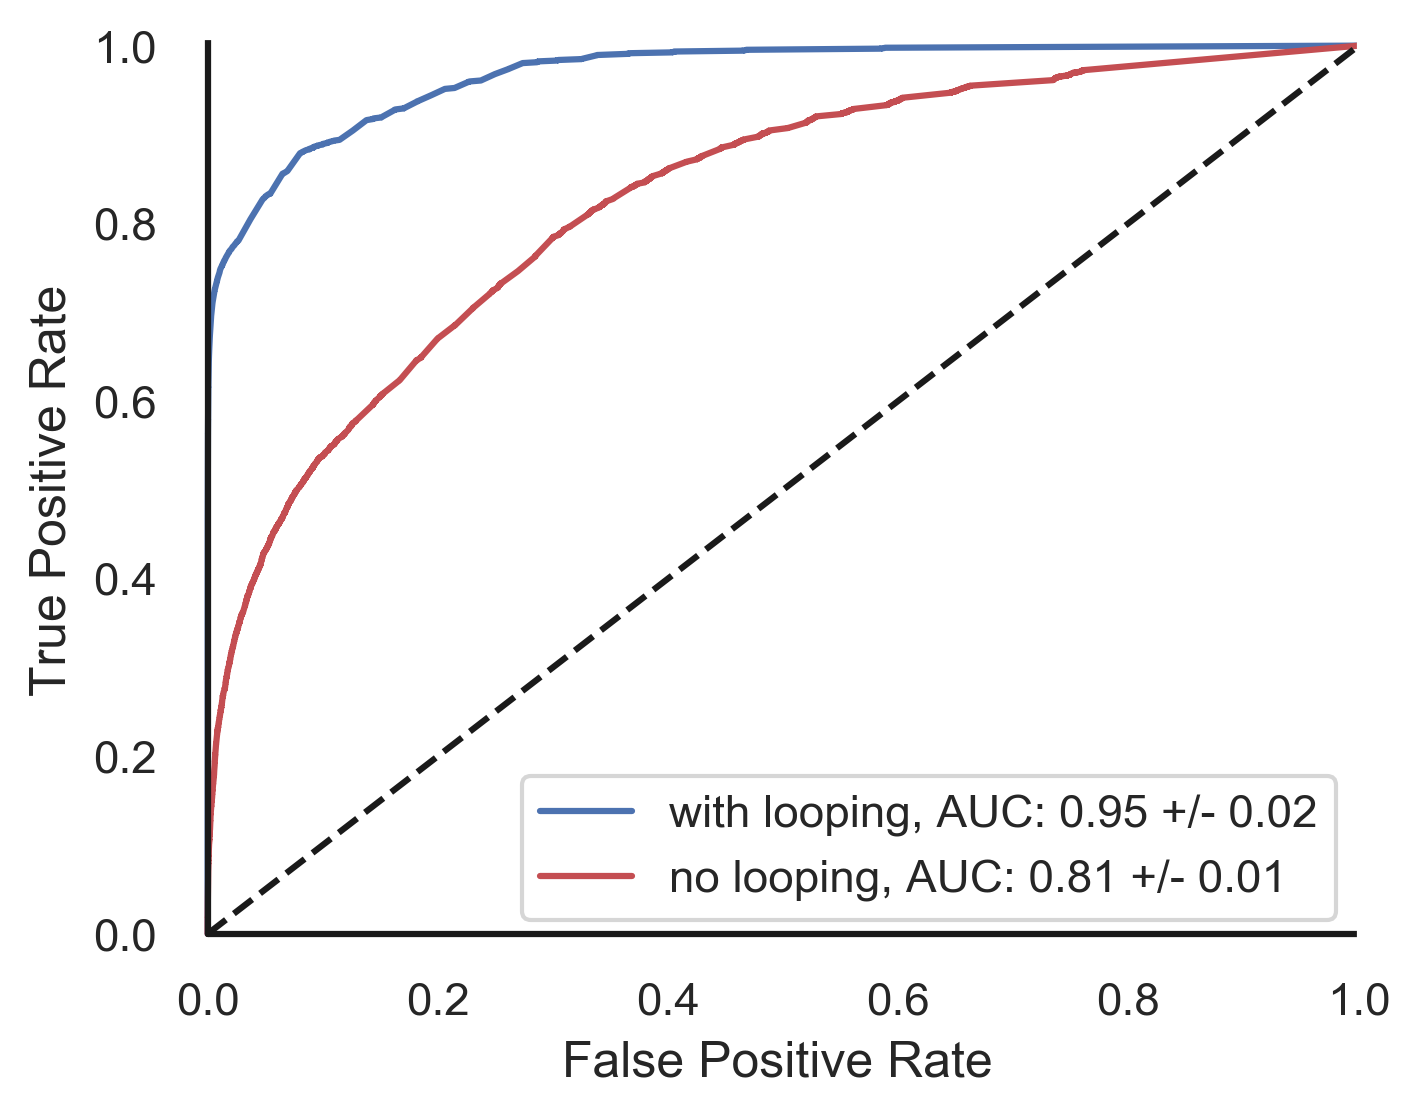

In [10]:
comb_auc_df = pd.read_csv(os.path.join(save_dir, 'dist_random_tf_only_auc_curve_values.csv'))
prom_auc_df = pd.read_csv(os.path.join(save_dir, 'prom_tf_only_auc_curve_values.csv'))
print(comb_auc_df.shape)
# with plt.style.context("seaborn-white"):
#     plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(figsize=(5,4),dpi=300)
ax.set_facecolor('white')
ax.plot(comb_auc_df['fpr'], comb_auc_df['tpr'],'b-',label='with looping, AUC: 0.95 +/- 0.02')
ax.plot(prom_auc_df['fpr'], prom_auc_df['tpr'],'r-',label='no looping, AUC: 0.81 +/- 0.01')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim(-0.01,1)
ax.set_ylim(-0.01,1.01)

ax.plot([0, 1.1], [0, 0], 'k')
ax.plot([0, 0], [0, 1.1], 'k')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# sns.scatterplot(x="fpr", y="tpr",data=comb_auc_df,
#                 marker=False,'-',
#            ax=ax,label='with looping')
# sns.scatterplot(x="fpr", y="tpr",data=prom_auc_df,
#                 marker=False,'-',
#            ax=ax,color='darkred',label='no looping')
ax.legend(loc='lower right',facecolor='white')
fig.savefig(os.path.join(save_dir, 'auc_comb_pro.pdf'))

In [ ]:
# %%time
# cv_results = cross_validate(clf, data_all_norm, labels_all_bin, groups = gene_groups, 
#                scoring=['accuracy', 'f1', 'roc_auc','precision', 'recall'])

In [ ]:
# for key, list_res in cv_results.items():
#     print(key, "%.2f +/- %.2f" % (list_res.mean(), list_res.std()))

In [ ]:
# scores = cross_val_score(clf, data_all_norm, labels_all_bin, scoring='accuracy', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Random Forest per gene'))


### 2A.2 - test different models

### 2A - only atac or only hichip

In [ ]:
data_all_varfilt_cols

In [ ]:
atac_rna_foot_cols = data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')] + ['num_atac_regions']+ ['num_snp'] + ['log_exp'] + ['gene_num']
atac_rna_foot_col_idx = list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')])[0]) + list(np.where(data_all_varfilt_cols=='num_atac_regions')[0])+ list(np.where(data_all_varfilt_cols=='num_snp')[0])
atac_rna_foot_col_idx+=     list(np.where(data_all_varfilt_cols=='log_exp')[0])
atac_rna_foot_col_idx+=     list(np.where(data_all_varfilt_cols=='gene_num')[0])

len(atac_rna_foot_col_idx)
    

In [ ]:
hichip_only_cols = ['num_loop_counts', 'num_loops']
hichip_only_col_idx = list(np.where(data_all_varfilt_cols=='num_loop_counts')[0])+list(np.where(data_all_varfilt_cols=='num_loops')[0])



In [ ]:
atac_only_cols = ['num_atac_regions']
atac_only_col_idx = list(np.where(data_all_varfilt_cols=='num_atac_regions')[0])


In [ ]:
rna_only_cols = ['log_exp', 'gene_num']
rna_only_col_idx = list(np.where(data_all_varfilt_cols=='log_exp')[0])+list(np.where(data_all_varfilt_cols=='gene_num')[0])


In [ ]:
foot_cols = list(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')]) + list(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('loop')])
foot_col_idx = list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')])[0]) 
foot_col_idx+=   list(np.where(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('loop')])[0]) 
len(foot_col_idx)
    

In [ ]:
all_indices = list(range(len(data_all_varfilt_cols)))

In [ ]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_labels,
                                                                            test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())


In [ ]:
test_labels_num = np.vectorize(tissue_to_num_dict.get)(test_labels)
test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)


In [ ]:
indices_to_test = [all_indices, hichip_only_col_idx, rna_only_col_idx, atac_only_col_idx, foot_col_idx, atac_rna_foot_col_idx]
test_name = ['All', 'HiChIP', 'RNA', 'ATAC', 'footprinting+looping', 'RNA+ATAC+footprinting']

In [ ]:
train_features[:,hichip_only_col_idx].shape

In [ ]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['data_type', 'fpr','tpr','auc'])
result_model_dict = {}
# Train the models and record the results
for idx_list, name in zip(indices_to_test, test_name):
    print(name)
    model = RandomForestClassifier(n_estimators=100, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0).fit(train_features[:, idx_list], train_labels)
    yproba = model.predict_proba(test_features[:, idx_list])

    # get micro roc-auc for each type of data
    fpr, tpr, _ = roc_curve(test_labels_bin.ravel(),  yproba.ravel())
    
    
    auc = roc_auc_score(test_labels, yproba, multi_class='ovo')
    print(auc)
    result_model_dict[name] = model
    result_table = result_table.append({'data_type':name, #'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the data_type as index labels
result_table.set_index('data_type', inplace=True)

In [ ]:
result_table.reset_index(inplace=True)
result_table.at[4,'data_type']= 'footprinting+looping'
result_table.set_index('data_type',inplace=True)

In [ ]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='grey', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# 3. Making Data table



In [38]:
groups_dict = {'Airway':'purple',
 'Astrocytes':'blue',
 'Bladder':'purple',
 'Colon':'green',
 'Esophageal':'green',
 'GDSD0':'purple',
 'GDSD3':'purple',
 'GDSD6':'purple',
 'GM12878':'grey',
 'HMEC':'purple',
 'Melanocytes':'blue',
 'Ovarian':'green',
 'Pancreas':'green',
 'Prostate':'purple',
 'Renal':'green',
 'Thyroid':'green',
 'Uterine':'purple'}


In [39]:
data_all_norm = pd.DataFrame(data_all_norm, columns = data_all_varfilt_cols)
data_all_norm = pd.concat([data_all_norm, pd.Series(tissue_labels,name='tissue'),pd.DataFrame(genes_all,columns=['gene'])],axis=1)
data_all_norm['group'] = data_all_norm.tissue.map(groups_dict)

In [40]:
data_all_norm[:5]

,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,ATF1_pro,ATF2_pro,ATF3_pro,ATF4_pro,ATF6_pro,ATF7_pro,...,NR4A3_loop,TFAP2B_loop,ZNF382_loop,CUX2_pro,CUX2_loop,E2F5_pro,E2F5_loop,tissue,gene,group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,A4GALT,purple
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,A4GNT,purple
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,AAMP,purple
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,AANAT,purple
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airway,ABAT,purple


# 3. activity by contact
what is the correlation between expression of a gene and 
- the number of unique loops it contains
- sum of read counts aggregated over all loops
- number of atac regions



In [7]:
# data_all['log_exp'] = np.log(np.array(exp_label)+1e-2)


In [8]:
# g = sns.jointplot("num_loop_counts", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_loop_counts']))
# plt.savefig(os.path.join(save_dir,'log_exp_v_num_loop_counts.pdf'))

In [9]:
# g2 = sns.jointplot("num_loops", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_loops']))
# plt.savefig(os.path.join(save_dir,'log_exp_v_num_loops.pdf'))

In [10]:
# g3 = sns.jointplot("num_atac_regions_loop", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_atac_regions_loop']))
# plt.savefig(os.path.join(save_dir,'log_exp_v_num_atac_regions_loop.pdf'))

In [11]:
# g4 = sns.jointplot("num_atac_regions_pro", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_atac_regions_pro']))
# plt.savefig(os.path.join(save_dir,'log_exp_v_num_atac_regions_pro.pdf'))

In [12]:
# %%time
# sns.pairplot(data_all[["num_loops", "num_loop_counts", "num_snp", "num_atac_regions"]], diag_kind="kde")#,kind="reg")
# plt.savefig(os.path.join(save_dir,'pairplot_main_count_feats.png'))

# 4 Clustering

Dimensionality reduction 

### 4A PCA

In [41]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap


In [42]:
n_comp = 50
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(data_all_norm[data_all_varfilt_cols].values)


In [43]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)

Explained variation per principal component: [0.13346017 0.02909632 0.02110627 0.01324257 0.01231929 0.01012229
 0.00961942 0.00927362 0.0087155  0.00805468 0.00761128 0.00751171
 0.0070542  0.00682634 0.00620546 0.00606266 0.00584873 0.00560537
 0.00557444 0.00534846 0.00516866 0.0050455  0.00493785 0.00480067
 0.00467263 0.00450299 0.00440997 0.00428759 0.00411418 0.00404836
 0.00398916 0.00390414 0.00379037 0.00376872 0.00366233 0.00363378
 0.00355591 0.00349549 0.00344823 0.0033709  0.00332058 0.00325554
 0.00320972 0.00317792 0.00310999 0.00305845 0.00300877 0.00299259
 0.00293413 0.00292878]


0.4322627030778958

In [44]:
for i in range(n_comp):
    data_all_norm['pc_'+str(i+1)] = pca_result[:,i]


In [45]:
data_all_norm.shape

(137054, 1033)

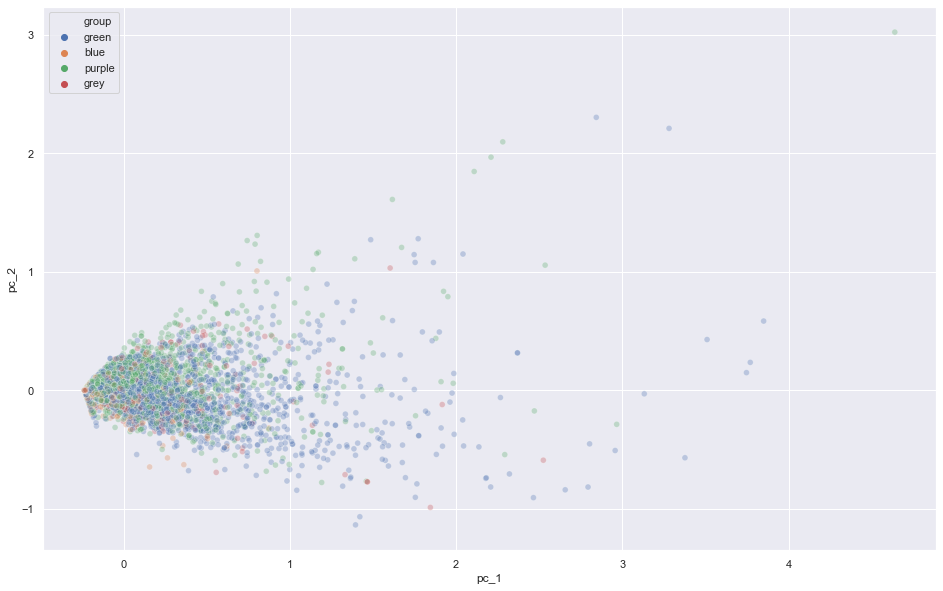

In [46]:
idx_choice = np.random.choice(data_all_norm.index.values, 10000)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pc_1', y='pc_2',
    hue="group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm.loc[idx_choice],#df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_pca12.png'))

In [47]:
# figure out what's responsible for a pc space
pc2_df = pd.DataFrame({'features':data_all_varfilt_cols, 'pc_2_coeff':pca.components_[1]})#,orient='index')
pc2_df['pc_2_coeff_abs'] = abs(pc2_df['pc_2_coeff'])
pc2_df.sort_values('pc_2_coeff_abs',ascending=False)

,features,pc_2_coeff,pc_2_coeff_abs
427,KLF13_loop,-0.155785,0.155785
394,HMGA1_loop,0.151293,0.151293
429,KLF3_loop,-0.143912,0.143912
526,SP1_loop,-0.135637,0.135637
528,SP3_loop,-0.131686,0.131686
...,...,...,...
953,HMX2_pro,0.000009,0.000009
90,HMGA2_pro,-0.000008,0.000008
92,HOXA1_pro,0.000008,0.000008
971,ZNF382_pro,-0.000005,0.000005


In [48]:
# idx_choice = np.random.choice(data_all_norm_df.index.values, 1000)

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x='pc_1', y='pc_2',
#     hue="gene",
# #     palette=sns.color_palette("hls", 10),
#     data=data_all_norm_df.loc[idx_choice],#df.loc[rndperm,:],
#     legend="brief",
#     alpha=0.3
# )
# plt.savefig(os.path.join('networks/representations', 'dimred_pca12_gene.png'))

### 4B: tsne

In [ ]:
data_all_norm

In [49]:
idx_choice = np.random.choice(data_all_norm.index.values, 10000)
data_all_norm_df_subset = data_all_norm.loc[idx_choice]

In [50]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result[idx_choice,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.024s...
[t-SNE] Computed neighbors for 10000 samples in 4.777s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.838264
[t-SNE] KL divergence after 300 iterations: 2.847366
t-SNE done! Time elapsed:

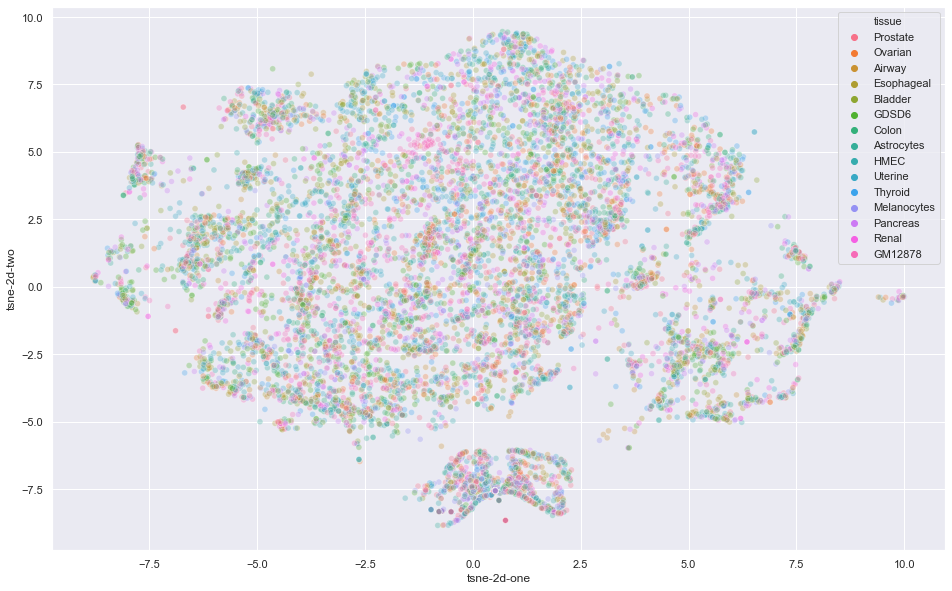

In [51]:
data_all_norm_df_subset['tsne-2d-one'] = tsne_results[:,0]
data_all_norm_df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_tsne2.png'))

### 4C UMAP

In [54]:
%%time
reducer = umap.UMAP()
embedding = reducer.fit_transform(pca_result[idx_choice,:])#pca_result[:,:])
embedding.shape

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


CPU times: user 23 s, sys: 567 ms, total: 23.6 s
Wall time: 19.3 s


(10000, 2)

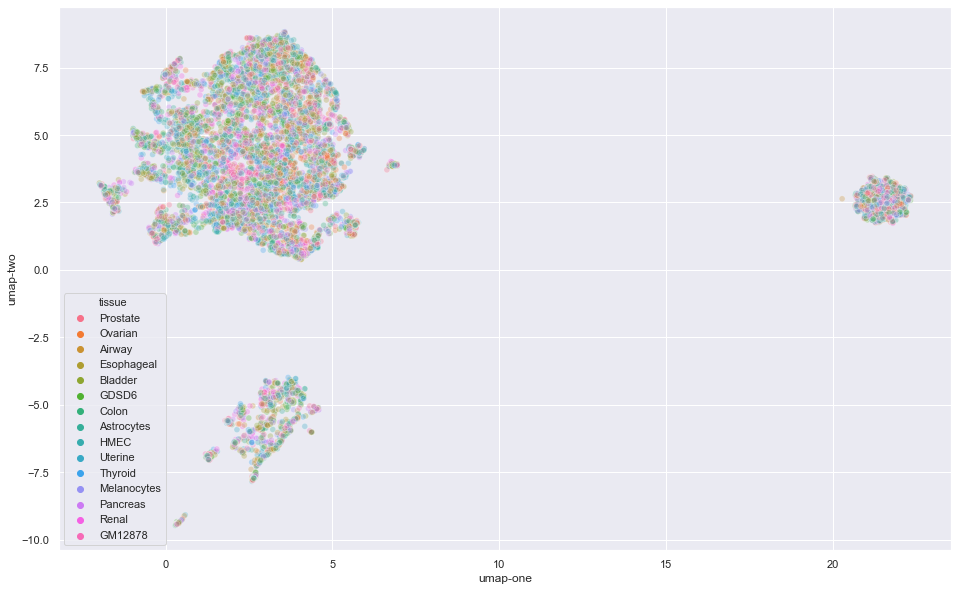

In [55]:
data_all_norm_df_subset['umap-one'] = embedding[:,0]
data_all_norm_df_subset['umap-two'] = embedding[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap.png'))

In [56]:
x = gene_variance_df.iloc[0,:]
print(x)
np.sqrt(x['umap-one']**2 + x['umap-two']**2)

NameError: name 'gene_variance_df' is not defined

In [ ]:
gene_variance_df = data_all_norm_df_subset.groupby('gene').agg({
    'umap-one':'std','umap-two':'std'
}).dropna()
gene_variance_df['sq_var'] = gene_variance_df.apply(lambda x: np.sqrt(x['umap-one']**2 + x['umap-two']**2),axis=1)
gene_variance_df.sort_values('sq_var',inplace=True)

In [ ]:
sns.distplot(gene_variance_df.sq_var)

In [ ]:
low_var_genes = gene_variance_df.index[gene_variance_df.sq_var < 1]
med_var_genes = gene_variance_df.index[(gene_variance_df.sq_var >= 1)&(gene_variance_df.sq_var < 7) ]
high_var_genes = gene_variance_df.index[gene_variance_df.sq_var >= 7]
len(low_var_genes), len(med_var_genes), len(high_var_genes)

In [ ]:
for x in low_var_genes:
    print(x)

In [ ]:
# cluster_one = sorted(set(data_all_norm_df_subset[data_all_norm_df_subset['umap-one']>10]['gene'].values))
# print(len(cluster_one))
# for x in cluster_one:
#     print(x)

In [ ]:
data_all_norm_df_subset['var_group'] = 'none'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(low_var_genes)]='low_var'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(med_var_genes)]='med_var'
data_all_norm_df_subset['var_group'][data_all_norm_df_subset.gene.isin(high_var_genes)]='high_var'

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="var_group",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap_vargroup.png'))

# 5. pairwise correlation

In [ ]:
pro_cols = [x for x in data_all_norm.columns.values if '_pro' in x]
loop_cols = [x for x in data_all_norm.columns.values if '_loop' in x]

In [ ]:
data_all_norm_tf = data_all_norm[pro_cols+loop_cols]
data_all_norm_tf[data_all_norm.tissue=='GDSD6'].shape

In [ ]:
%%time
# might take awhile
data_all_norm_tf_corr_GDSD6 = data_all_norm_tf[data_all_norm.tissue=='GDSD6'].corr()

In [ ]:
save_path = os.path.join(save_dir, save_prefix+'_GDSD6_tfcorr.csv')
print(save_path)
data_all_norm_tf_corr_GDSD6.loc[pro_cols,loop_cols].fillna(0).to_csv(save_path)

In [ ]:
os.path.join(save_dir, save_prefix+'_tfcorr.csv')